Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d



In [1]:
# Version = "v1" # starter model
# Version = "v2" # compare treat Vs.ctrl and minor modifications, StratifiedKFold
Version = "v3" # minor modifications、Add debug mode

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 5
    Num_boost_round=10000
    Early_stopping_rounds=20
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

# Training Utils

In [8]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    
    target = train_targets_scored[target_col]
    ctr = train[train.cp_type==0].copy().reset_index(drop=True)
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    ctr["target"] = 0

    X_train = pd.concat([trt, ctr],axis=0).reset_index(drop=True)
    y_train = X_train["target"]
    
    X_train = X_train.drop(["sig_id", "target", "cp_type"], axis=1)
    X_test = test.drop(["sig_id", "cp_type"], axis=1)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    score = 0
    
    for fold_, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train[train_index]
        y_val = y_train[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= {fold_+1}fold lightgbm =================================")

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=20,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)


        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(y_train, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [9]:
def show_feature_importance(feature_importance_df):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:100].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [10]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [11]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [12]:
train, test = label_encoding(train, test, ['cp_type', 'cp_dose'])

In [13]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,1,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,1,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,1,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,1,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


# Modeling

In [14]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'num_leaves': 24,
    'max_depth': 5,
    'objective': 'binary',
    'learning_rate': Learning_rate
}

categorical_cols = ['cp_time', 'cp_dose']
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [15]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models,  = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[2:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

len(train_index) : 941
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0135585	valid_1's binary_logloss: 0.0381451
[40]	training's binary_logloss: 0.00685197	valid_1's binary_logloss: 0.0349226
[60]	training's binary_logloss: 0.00372096	valid_1's binary_logloss: 0.0340594


len(train_index) : 942
len(valid_index) : 941
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00311894	valid_1's binary_logloss: 0.0336927
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0150128	valid_1's binary_logloss: 0.0367205
[40]	training's binary_logloss: 0.00747461	valid_1's binary_logloss: 0.0346958


5-alpha_reductase_inhibitor logloss: 0.0341905726752713
len(train_index) : 942
len(valid_index) : 942


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.00561815	valid_1's binary_logloss: 0.034689


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0162581	valid_1's binary_logloss: 0.0458677
[40]	training's binary_logloss: 0.00814828	valid_1's binary_logloss: 0.0433347


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00443074	valid_1's binary_logloss: 0.0427138
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.00597028	valid_1's binary_logloss: 0.0425985
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0153341	valid_1's binary_logloss: 0.0433683
[40]	training's binary_logloss: 0.00771093	valid_1's binary_logloss: 0.0406359
[60]	training's binary_logloss: 0.00415615	valid_1's binary_logloss: 0.0401601
[80]	training's binary_logloss: 0.00229426	valid_1's binary_logloss: 0.0398065


11-beta-hsd1_inhibitor logloss: 0.04112415659283485


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.00216455	valid_1's binary_logloss: 0.0396498


len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0435489	valid_1's binary_logloss: 0.065465
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0241527	valid_1's binary_logloss: 0.0651224
[40]	training's binary_logloss: 0.0122084	valid_1's binary_logloss: 0.0649971
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.0147466	valid_1's binary_logloss: 0.0645743


acat_inhibitor logloss: 0.06501963398562491
len(train_index) : 1028
len(valid_index) : 1028
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.166383	valid_1's binary_logloss: 0.257884
[40]	training's binary_logloss: 0.106397	valid_1's binary_logloss: 0.24102
[60]	training's binary_logloss: 0.0693081	valid_1's binary_logloss: 0.232366
[80]	training's binary_logloss: 0.0473612	valid_1's binary_logloss: 0.228961


len(train_index) : 1028
len(valid_index) : 1028
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.0422394	valid_1's binary_logloss: 0.227904
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.171842	valid_1's binary_logloss: 0.256847
[40]	training's binary_logloss: 0.113072	valid_1's binary_logloss: 0.235345
[60]	training's binary_logloss: 0.0778781	valid_1's binary_logloss: 0.225151
[80]	training's binary_logloss: 0.0548367	valid_1's binary_logloss: 0.219923
[100]	training's binary_logloss: 0.0392923	valid_1's binary_logloss: 0.217423
[120]	training's binary_logloss: 0.0283365	valid_1's binary_logloss: 0.216669


acetylcholine_receptor_agonist logloss: 0.2222406220238216


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0278795	valid_1's binary_logloss: 0.216577


len(train_index) : 1083
len(valid_index) : 1084
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.219358	valid_1's binary_logloss: 0.304389
[40]	training's binary_logloss: 0.138886	valid_1's binary_logloss: 0.263599
[60]	training's binary_logloss: 0.0918732	valid_1's binary_logloss: 0.239478
[80]	training's binary_logloss: 0.063061	valid_1's binary_logloss: 0.22375
[100]	training's binary_logloss: 0.0437268	valid_1's binary_logloss: 0.215194
[120]	training's binary_logloss: 0.0307662	valid_1's binary_logloss: 0.211724
[140]	training's binary_logloss: 0.0219744	valid_1's binary_logloss: 0.210772
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0251627	valid_1's binary_logloss: 0.210064


len(train_index) : 1084
len(valid_index) : 1083
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.225872	valid_1's binary_logloss: 0.294156
[40]	training's binary_logloss: 0.147725	valid_1's binary_logloss: 0.246784
[60]	training's binary_logloss: 0.101716	valid_1's binary_logloss: 0.217768
[80]	training's binary_logloss: 0.0713656	valid_1's binary_logloss: 0.199762
[100]	training's binary_logloss: 0.0506361	valid_1's binary_logloss: 0.189433
[120]	training's binary_logloss: 0.0361805	valid_1's binary_logloss: 0.182877
[140]	training's binary_logloss: 0.0259791	valid_1's binary_logloss: 0.179687
[160]	training's binary_logloss: 0.0185233	valid_1's binary_logloss: 0.178319


acetylcholine_receptor_antagonist logloss: 0.194095909562167


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0167658	valid_1's binary_logloss: 0.178113


len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0690064	valid_1's binary_logloss: 0.134796
[40]	training's binary_logloss: 0.0379272	valid_1's binary_logloss: 0.120748
[60]	training's binary_logloss: 0.0225167	valid_1's binary_logloss: 0.113176
[80]	training's binary_logloss: 0.0139551	valid_1's binary_logloss: 0.110226
[100]	training's binary_logloss: 0.00879262	valid_1's binary_logloss: 0.110233


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[95]	training's binary_logloss: 0.00986437	valid_1's binary_logloss: 0.10975
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0666922	valid_1's binary_logloss: 0.135976
[40]	training's binary_logloss: 0.0358788	valid_1's binary_logloss: 0.12724
[60]	training's binary_logloss: 0.0213547	valid_1's binary_logloss: 0.124708
[80]	training's binary_logloss: 0.0129288	valid_1's binary_logloss: 0.124354
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.0156582	valid_1's binary_logloss: 0.123878


acetylcholinesterase_inhibitor logloss: 0.11681028792866632
len(train_index) : 960
len(valid_index) : 960
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0544582	valid_1's binary_logloss: 0.11076
[40]	training's binary_logloss: 0.0307887	valid_1's binary_logloss: 0.108693


len(train_index) : 960
len(valid_index) : 960
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0250786	valid_1's binary_logloss: 0.10775
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0521924	valid_1's binary_logloss: 0.120774
[40]	training's binary_logloss: 0.0286165	valid_1's binary_logloss: 0.120327
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0349145	valid_1's binary_logloss: 0.119254


adenosine_receptor_agonist logloss: 0.11350199372860653
len(train_index) : 981
len(valid_index) : 981
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0891231	valid_1's binary_logloss: 0.151328
[40]	training's binary_logloss: 0.0510351	valid_1's binary_logloss: 0.130982
[60]	training's binary_logloss: 0.0310579	valid_1's binary_logloss: 0.120657
[80]	training's binary_logloss: 0.0196808	valid_1's binary_logloss: 0.1151
[100]	training's binary_logloss: 0.0124276	valid_1's binary_logloss: 0.114245


len(train_index) : 981
len(valid_index) : 981
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[97]	training's binary_logloss: 0.0133366	valid_1's binary_logloss: 0.113961
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0926336	valid_1's binary_logloss: 0.15338
[40]	training's binary_logloss: 0.051572	valid_1's binary_logloss: 0.130763
[60]	training's binary_logloss: 0.0315516	valid_1's binary_logloss: 0.121587
[80]	training's binary_logloss: 0.0195774	valid_1's binary_logloss: 0.118024


adenosine_receptor_antagonist logloss: 0.1155811819586111


Early stopping, best iteration is:
[89]	training's binary_logloss: 0.0158731	valid_1's binary_logloss: 0.117201


len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


[20]	training's binary_logloss: 0.0102661	valid_1's binary_logloss: 0.0338429
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.0140697	valid_1's binary_logloss: 0.0337676
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.01012	valid_1's binary_logloss: 0.0296271


adenylyl_cyclase_activator logloss: 0.03145272394736923


[40]	training's binary_logloss: 0.00513877	valid_1's binary_logloss: 0.0292474
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.00663272	valid_1's binary_logloss: 0.0291378


len(train_index) : 1068
len(valid_index) : 1068
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.21013	valid_1's binary_logloss: 0.275499
[40]	training's binary_logloss: 0.133783	valid_1's binary_logloss: 0.226263
[60]	training's binary_logloss: 0.0886118	valid_1's binary_logloss: 0.197414
[80]	training's binary_logloss: 0.0605099	valid_1's binary_logloss: 0.178305
[100]	training's binary_logloss: 0.0417972	valid_1's binary_logloss: 0.164661
[120]	training's binary_logloss: 0.0291523	valid_1's binary_logloss: 0.156779
[140]	training's binary_logloss: 0.020406	valid_1's binary_logloss: 0.152476
[160]	training's binary_logloss: 0.0145345	valid_1's binary_logloss: 0.149654
[180]	training's binary_logloss: 0.0102713	valid_1's binary_logloss: 0.148649
[200]	training's binary_logloss: 0.00732471	valid_1's binary_logloss: 0.14804


len(train_index) : 1068
len(valid_index) : 1068
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00694918	valid_1's binary_logloss: 0.147801
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.193114	valid_1's binary_logloss: 0.285106
[40]	training's binary_logloss: 0.119022	valid_1's binary_logloss: 0.247761
[60]	training's binary_logloss: 0.0773653	valid_1's binary_logloss: 0.229118
[80]	training's binary_logloss: 0.0507715	valid_1's binary_logloss: 0.217628
[100]	training's binary_logloss: 0.033927	valid_1's binary_logloss: 0.21622


adrenergic_receptor_agonist logloss: 0.1818507024824078


Early stopping, best iteration is:
[104]	training's binary_logloss: 0.031344	valid_1's binary_logloss: 0.2159


len(train_index) : 1113
len(valid_index) : 1113
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.253674	valid_1's binary_logloss: 0.34575
[40]	training's binary_logloss: 0.167067	valid_1's binary_logloss: 0.300277
[60]	training's binary_logloss: 0.114656	valid_1's binary_logloss: 0.269736
[80]	training's binary_logloss: 0.0801291	valid_1's binary_logloss: 0.252719
[100]	training's binary_logloss: 0.0561437	valid_1's binary_logloss: 0.241989
[120]	training's binary_logloss: 0.0400271	valid_1's binary_logloss: 0.236508


len(train_index) : 1113
len(valid_index) : 1113
================================= 2fold lightgbm =================================


[140]	training's binary_logloss: 0.0290165	valid_1's binary_logloss: 0.23499
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0339392	valid_1's binary_logloss: 0.23451
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.25132	valid_1's binary_logloss: 0.336257
[40]	training's binary_logloss: 0.162437	valid_1's binary_logloss: 0.290586
[60]	training's binary_logloss: 0.108568	valid_1's binary_logloss: 0.26495
[80]	training's binary_logloss: 0.0762983	valid_1's binary_logloss: 0.250645
[100]	training's binary_logloss: 0.054131	valid_1's binary_logloss: 0.243657
[120]	training's binary_logloss: 0.0395681	valid_1's binary_logloss: 0.240765
[140]	training's binary_logloss: 0.0290749	valid_1's binary_logloss: 0.239035


adrenergic_receptor_antagonist logloss: 0.23668517480917206


[160]	training's binary_logloss: 0.0214259	valid_1's binary_logloss: 0.239767
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0247578	valid_1's binary_logloss: 0.23886


len(train_index) : 966
len(valid_index) : 966
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0578739	valid_1's binary_logloss: 0.0992949
[40]	training's binary_logloss: 0.0301296	valid_1's binary_logloss: 0.0867877
[60]	training's binary_logloss: 0.016871	valid_1's binary_logloss: 0.0826132
[80]	training's binary_logloss: 0.00974385	valid_1's binary_logloss: 0.0817321


len(train_index) : 966
len(valid_index) : 966
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.0108898	valid_1's binary_logloss: 0.0815319
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0567874	valid_1's binary_logloss: 0.0916749
[40]	training's binary_logloss: 0.0308712	valid_1's binary_logloss: 0.0788658
[60]	training's binary_logloss: 0.0177642	valid_1's binary_logloss: 0.0730604
[80]	training's binary_logloss: 0.0103502	valid_1's binary_logloss: 0.06983
[100]	training's binary_logloss: 0.00610339	valid_1's binary_logloss: 0.0694181
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00734198	valid_1's binary_logloss: 0.0689441


akt_inhibitor logloss: 0.07523801681140356
len(train_index) : 936
len(valid_index) : 937
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00514789	valid_1's binary_logloss: 0.0116462
[40]	training's binary_logloss: 0.00268884	valid_1's binary_logloss: 0.00956941
[60]	training's binary_logloss: 0.00150773	valid_1's binary_logloss: 0.00843786
[80]	training's binary_logloss: 0.000870575	valid_1's binary_logloss: 0.00767038
[100]	training's binary_logloss: 0.000511482	valid_1's binary_logloss: 0.00729147
[120]	training's binary_logloss: 0.000304283	valid_1's binary_logloss: 0.00702669
[140]	training's binary_logloss: 0.000179922	valid_1's binary_logloss: 0.00662653
[160]	training's binary_logloss: 0.000105744	valid_1's binary_logloss: 0.00658047
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.000123915	valid_1's binary_logloss: 0.00645289


len(train_index) : 937
len(valid_index) : 936
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00680628	valid_1's binary_logloss: 0.0121451
[40]	training's binary_logloss: 0.00343611	valid_1's binary_logloss: 0.0103928
[60]	training's binary_logloss: 0.00185753	valid_1's binary_logloss: 0.00960391
[80]	training's binary_logloss: 0.0010303	valid_1's binary_logloss: 0.00914566
[100]	training's binary_logloss: 0.000578368	valid_1's binary_logloss: 0.00889461
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.000612923	valid_1's binary_logloss: 0.00887333


aldehyde_dehydrogenase_inhibitor logloss: 0.007662464143262385
len(train_index) : 954
len(valid_index) : 954
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0376121	valid_1's binary_logloss: 0.0764958
[40]	training's binary_logloss: 0.0193984	valid_1's binary_logloss: 0.0704386


len(train_index) : 954
len(valid_index) : 954
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.0105839	valid_1's binary_logloss: 0.0697819
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0142001	valid_1's binary_logloss: 0.0692947
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.04128	valid_1's binary_logloss: 0.0688277
[40]	training's binary_logloss: 0.0213874	valid_1's binary_logloss: 0.0573337
[60]	training's binary_logloss: 0.0120383	valid_1's binary_logloss: 0.0511282
[80]	training's binary_logloss: 0.00697222	valid_1's binary_logloss: 0.0495784
[100]	training's binary_logloss: 0.00411328	valid_1's binary_logloss: 0.0492476
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.00480588	valid_1's binary_logloss: 0.0491257


alk_inhibitor logloss: 0.059210213042753805
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0128817	valid_1's binary_logloss: 0.0380558


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[24]	training's binary_logloss: 0.0109881	valid_1's binary_logloss: 0.0378914
Training until validation scores don't improve for 10 rounds


ampk_activator logloss: 0.038113723908345006
len(train_index) : 939
len(valid_index) : 939


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0359888	valid_1's binary_logloss: 0.038336


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0355526	valid_1's binary_logloss: 0.0377926
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0106697	valid_1's binary_logloss: 0.0361461


analgesic logloss: 0.0369305225426096
len(train_index) : 957
len(valid_index) : 957


Early stopping, best iteration is:
[18]	training's binary_logloss: 0.0115123	valid_1's binary_logloss: 0.0360685


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0434935	valid_1's binary_logloss: 0.097068
[40]	training's binary_logloss: 0.0230893	valid_1's binary_logloss: 0.0874664
[60]	training's binary_logloss: 0.0132409	valid_1's binary_logloss: 0.0852061
[80]	training's binary_logloss: 0.00791907	valid_1's binary_logloss: 0.0844342
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00946187	valid_1's binary_logloss: 0.0839256


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0463484	valid_1's binary_logloss: 0.0921373
[40]	training's binary_logloss: 0.0245566	valid_1's binary_logloss: 0.0870767
[60]	training's binary_logloss: 0.0141117	valid_1's binary_logloss: 0.0873041
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.017042	valid_1's binary_logloss: 0.0865787


androgen_receptor_agonist logloss: 0.08525218322485621
len(train_index) : 977
len(valid_index) : 978
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.080039	valid_1's binary_logloss: 0.151524
[40]	training's binary_logloss: 0.0458277	valid_1's binary_logloss: 0.138806
[60]	training's binary_logloss: 0.0278088	valid_1's binary_logloss: 0.133413
[80]	training's binary_logloss: 0.0173702	valid_1's binary_logloss: 0.131208


len(train_index) : 978
len(valid_index) : 977
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.0178135	valid_1's binary_logloss: 0.131127
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0808759	valid_1's binary_logloss: 0.15052
[40]	training's binary_logloss: 0.047302	valid_1's binary_logloss: 0.138009
[60]	training's binary_logloss: 0.0300458	valid_1's binary_logloss: 0.129351
[80]	training's binary_logloss: 0.0194133	valid_1's binary_logloss: 0.123744


androgen_receptor_antagonist logloss: 0.1267624414590522


[100]	training's binary_logloss: 0.012612	valid_1's binary_logloss: 0.122957
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.0153575	valid_1's binary_logloss: 0.122394


len(train_index) : 973
len(valid_index) : 973
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0711913	valid_1's binary_logloss: 0.136605
[40]	training's binary_logloss: 0.0386595	valid_1's binary_logloss: 0.126705
[60]	training's binary_logloss: 0.0226109	valid_1's binary_logloss: 0.120953
[80]	training's binary_logloss: 0.0135593	valid_1's binary_logloss: 0.118882


len(train_index) : 973
len(valid_index) : 973
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.0128833	valid_1's binary_logloss: 0.118815
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0714361	valid_1's binary_logloss: 0.133272
[40]	training's binary_logloss: 0.0390541	valid_1's binary_logloss: 0.118137
[60]	training's binary_logloss: 0.023091	valid_1's binary_logloss: 0.112605
[80]	training's binary_logloss: 0.0140005	valid_1's binary_logloss: 0.111894
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.0170501	valid_1's binary_logloss: 0.111534


anesthetic_-_local logloss: 0.11517458820710982
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0332286	valid_1's binary_logloss: 0.0903233
[40]	training's binary_logloss: 0.0174449	valid_1's binary_logloss: 0.0890849


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0202661	valid_1's binary_logloss: 0.0888562
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.03458	valid_1's binary_logloss: 0.0821725
[40]	training's binary_logloss: 0.0179707	valid_1's binary_logloss: 0.0804457


angiogenesis_inhibitor logloss: 0.08447470443059943
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0164344	valid_1's binary_logloss: 0.0800932
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0351247	valid_1's binary_logloss: 0.0818948


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0255568	valid_1's binary_logloss: 0.0811831
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0347959	valid_1's binary_logloss: 0.0764897
[40]	training's binary_logloss: 0.0180871	valid_1's binary_logloss: 0.0728946


angiotensin_receptor_antagonist logloss: 0.07686383413450287


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0146816	valid_1's binary_logloss: 0.07254


len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0680476	valid_1's binary_logloss: 0.127176
[40]	training's binary_logloss: 0.0376899	valid_1's binary_logloss: 0.119949


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.0218187	valid_1's binary_logloss: 0.119319
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0285222	valid_1's binary_logloss: 0.118384
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0698843	valid_1's binary_logloss: 0.125523
[40]	training's binary_logloss: 0.0387359	valid_1's binary_logloss: 0.115078
[60]	training's binary_logloss: 0.0228696	valid_1's binary_logloss: 0.111497
[80]	training's binary_logloss: 0.0139831	valid_1's binary_logloss: 0.110901


anti-inflammatory logloss: 0.11462935598434063


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.0118633	valid_1's binary_logloss: 0.110871


len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0175052	valid_1's binary_logloss: 0.0205024
Training until validation scores don't improve for 10 rounds


antiarrhythmic logloss: 0.02053364017109943
len(train_index) : 954
len(valid_index) : 955
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00871046	valid_1's binary_logloss: 0.0205649
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0428833	valid_1's binary_logloss: 0.0934817
[40]	training's binary_logloss: 0.0232463	valid_1's binary_logloss: 0.0939108
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.0276616	valid_1's binary_logloss: 0.0925955


len(train_index) : 955
len(valid_index) : 954
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.045322	valid_1's binary_logloss: 0.0892374
[40]	training's binary_logloss: 0.0245161	valid_1's binary_logloss: 0.0844889


antibiotic logloss: 0.08843476513722996
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0224747	valid_1's binary_logloss: 0.0842697
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.010979	valid_1's binary_logloss: 0.0374018
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0134901	valid_1's binary_logloss: 0.0372685


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0107957	valid_1's binary_logloss: 0.0321573


anticonvulsant logloss: 0.03433966268264178


[40]	training's binary_logloss: 0.00543023	valid_1's binary_logloss: 0.0315069
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.00703762	valid_1's binary_logloss: 0.0314108


len(train_index) : 939
len(valid_index) : 940
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0102998	valid_1's binary_logloss: 0.0408215
[40]	training's binary_logloss: 0.0052985	valid_1's binary_logloss: 0.0387791


len(train_index) : 940
len(valid_index) : 939
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00290386	valid_1's binary_logloss: 0.0385158
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.00389908	valid_1's binary_logloss: 0.0383581
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0127162	valid_1's binary_logloss: 0.0332085
[40]	training's binary_logloss: 0.0063351	valid_1's binary_logloss: 0.0312591
[60]	training's binary_logloss: 0.00339923	valid_1's binary_logloss: 0.0302737


antifungal logloss: 0.03431803122587487
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.00339923	valid_1's binary_logloss: 0.0302737
Training until validation scores don't improve for 10 rounds


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.036597	valid_1's binary_logloss: 0.0388804
Training until validation scores don't improve for 10 rounds


antihistamine logloss: 0.038334168859606395
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0297186	valid_1's binary_logloss: 0.0377879
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0167308	valid_1's binary_logloss: 0.0503094


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[19]	training's binary_logloss: 0.0173848	valid_1's binary_logloss: 0.0502575
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0173975	valid_1's binary_logloss: 0.0477049


antimalarial logloss: 0.04881974860407817


Early stopping, best iteration is:
[17]	training's binary_logloss: 0.0197954	valid_1's binary_logloss: 0.047382


len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.063738	valid_1's binary_logloss: 0.129326
[40]	training's binary_logloss: 0.0360124	valid_1's binary_logloss: 0.122555
[60]	training's binary_logloss: 0.0218142	valid_1's binary_logloss: 0.121238


len(train_index) : 970
len(valid_index) : 969


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.0198507	valid_1's binary_logloss: 0.120644


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.073951	valid_1's binary_logloss: 0.135304
[40]	training's binary_logloss: 0.0439654	valid_1's binary_logloss: 0.124716
[60]	training's binary_logloss: 0.0281702	valid_1's binary_logloss: 0.120212
[80]	training's binary_logloss: 0.018449	valid_1's binary_logloss: 0.119169


antioxidant logloss: 0.11979874327261522
len(train_index) : 951
len(valid_index) : 951


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.0197204	valid_1's binary_logloss: 0.118953


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0350268	valid_1's binary_logloss: 0.075918
[40]	training's binary_logloss: 0.0180575	valid_1's binary_logloss: 0.0708366
[60]	training's binary_logloss: 0.0102268	valid_1's binary_logloss: 0.0701389


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.00968003	valid_1's binary_logloss: 0.0698833
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0341187	valid_1's binary_logloss: 0.0844539
[40]	training's binary_logloss: 0.018114	valid_1's binary_logloss: 0.0784482
[60]	training's binary_logloss: 0.0104386	valid_1's binary_logloss: 0.0768793


antiprotozoal logloss: 0.07324488979554679


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.0113396	valid_1's binary_logloss: 0.0766065


len(train_index) : 944
len(valid_index) : 945
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0202952	valid_1's binary_logloss: 0.0610576


len(train_index) : 945
len(valid_index) : 944
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[18]	training's binary_logloss: 0.0220559	valid_1's binary_logloss: 0.0608929
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0220966	valid_1's binary_logloss: 0.0555228
[40]	training's binary_logloss: 0.011018	valid_1's binary_logloss: 0.0519169


antiviral logloss: 0.05619323036994975
len(train_index) : 957
len(valid_index) : 958
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.00832547	valid_1's binary_logloss: 0.0514886
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0472567	valid_1's binary_logloss: 0.0993404
[40]	training's binary_logloss: 0.0251966	valid_1's binary_logloss: 0.0927815
[60]	training's binary_logloss: 0.014439	valid_1's binary_logloss: 0.0916022


len(train_index) : 958
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[56]	training's binary_logloss: 0.0161325	valid_1's binary_logloss: 0.0913251
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0491277	valid_1's binary_logloss: 0.0963549
[40]	training's binary_logloss: 0.0265981	valid_1's binary_logloss: 0.0884671
[60]	training's binary_logloss: 0.0154758	valid_1's binary_logloss: 0.0858959


apoptosis_stimulant logloss: 0.08843916305114448
len(train_index) : 956
len(valid_index) : 957
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.0135715	valid_1's binary_logloss: 0.0855502
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0445393	valid_1's binary_logloss: 0.102707


len(train_index) : 957
len(valid_index) : 956
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[27]	training's binary_logloss: 0.0349784	valid_1's binary_logloss: 0.101048
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0486522	valid_1's binary_logloss: 0.102664
[40]	training's binary_logloss: 0.0269009	valid_1's binary_logloss: 0.0962564
[60]	training's binary_logloss: 0.0159497	valid_1's binary_logloss: 0.0923823


aromatase_inhibitor logloss: 0.0966451944046936
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0168163	valid_1's binary_logloss: 0.092238
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00535121	valid_1's binary_logloss: 0.0187001


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00270193	valid_1's binary_logloss: 0.0184167
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.00374121	valid_1's binary_logloss: 0.018265
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00522725	valid_1's binary_logloss: 0.0161129
[40]	training's binary_logloss: 0.00260993	valid_1's binary_logloss: 0.0155914


atm_kinase_inhibitor logloss: 0.016856622430221714
len(train_index) : 933
len(valid_index) : 934
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.00229778	valid_1's binary_logloss: 0.0154483


len(train_index) : 934
len(valid_index) : 933
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.0369794
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00172294	valid_1's binary_logloss: 0.000726366
[40]	training's binary_logloss: 0.000870255	valid_1's binary_logloss: 0.000420917
[60]	training's binary_logloss: 0.000472247	valid_1's binary_logloss: 0.000242646
[80]	training's binary_logloss: 0.000262798	valid_1's binary_logloss: 0.000139852
[100]	training's binary_logloss: 0.000148011	valid_1's binary_logloss: 8.09437e-05
[120]	training's binary_logloss: 8.39139e-05	valid_1's binary_logloss: 4.69325e-05
[140]	training's binary_logloss: 4.7771e-05	valid_1's binary_logloss: 2.74122e-05
[160]	training's binary_logloss: 2.72776e-05	valid_1's binary_logloss: 1.60517e-05
[180]	training's binary_logloss: 1.5611e-05	valid_1's binary_logloss: 9.46924e-06
[200]	training's binary_logloss: 8

atp-sensitive_potassium_channel_antagonist logloss: 0.018500406395202947
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00979393	valid_1's binary_logloss: 0.0119065
[40]	training's binary_logloss: 0.0051925	valid_1's binary_logloss: 0.0075803
[60]	training's binary_logloss: 0.00296024	valid_1's binary_logloss: 0.00534093
[80]	training's binary_logloss: 0.00168428	valid_1's binary_logloss: 0.00405544
[100]	training's binary_logloss: 0.00095995	valid_1's binary_logloss: 0.00321074
[120]	training's binary_logloss: 0.000543152	valid_1's binary_logloss: 0.002526
[140]	training's binary_logloss: 0.000307597	valid_1's binary_logloss: 0.00212983
[160]	training's binary_logloss: 0.000174719	valid_1's binary_logloss: 0.00185117
[180]	training's binary_logloss: 9.9001e-05	valid_1's binary_logloss: 0.00157427
[200]	training's binary_logloss: 5.67434e-05	valid_1's binary_logloss: 0.00137761


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[209]	training's binary_logloss: 4.43599e-05	valid_1's binary_logloss: 0.00127328
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00963199	valid_1's binary_logloss: 0.0207789
[40]	training's binary_logloss: 0.00502454	valid_1's binary_logloss: 0.0171234
[60]	training's binary_logloss: 0.00281869	valid_1's binary_logloss: 0.015169


atp_synthase_inhibitor logloss: 0.007972992330974649


[80]	training's binary_logloss: 0.00161742	valid_1's binary_logloss: 0.0147667
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.00213998	valid_1's binary_logloss: 0.0146727


len(train_index) : 981
len(valid_index) : 982
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0812776	valid_1's binary_logloss: 0.126462
[40]	training's binary_logloss: 0.0457069	valid_1's binary_logloss: 0.10992
[60]	training's binary_logloss: 0.0270627	valid_1's binary_logloss: 0.104241
[80]	training's binary_logloss: 0.0160348	valid_1's binary_logloss: 0.102473


len(train_index) : 982
len(valid_index) : 981
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.0182148	valid_1's binary_logloss: 0.102174
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0835054	valid_1's binary_logloss: 0.133142
[40]	training's binary_logloss: 0.0460644	valid_1's binary_logloss: 0.113128
[60]	training's binary_logloss: 0.0267548	valid_1's binary_logloss: 0.103861
[80]	training's binary_logloss: 0.0161356	valid_1's binary_logloss: 0.0985105


atpase_inhibitor logloss: 0.09987554170244094


Early stopping, best iteration is:
[88]	training's binary_logloss: 0.013255	valid_1's binary_logloss: 0.0975744


len(train_index) : 942
len(valid_index) : 943
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0160863	valid_1's binary_logloss: 0.0294476
[40]	training's binary_logloss: 0.00839673	valid_1's binary_logloss: 0.0238773
[60]	training's binary_logloss: 0.00459068	valid_1's binary_logloss: 0.0219698
[80]	training's binary_logloss: 0.00257025	valid_1's binary_logloss: 0.0212045


len(train_index) : 943
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.00244464	valid_1's binary_logloss: 0.0210998
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0181785	valid_1's binary_logloss: 0.0320745
[40]	training's binary_logloss: 0.00888137	valid_1's binary_logloss: 0.0270927
[60]	training's binary_logloss: 0.00468707	valid_1's binary_logloss: 0.0256467
[80]	training's binary_logloss: 0.00255607	valid_1's binary_logloss: 0.0249631


atr_kinase_inhibitor logloss: 0.022814059645353223
len(train_index) : 981
len(valid_index) : 981
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[89]	training's binary_logloss: 0.00195718	valid_1's binary_logloss: 0.0245301
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0778799	valid_1's binary_logloss: 0.110915
[40]	training's binary_logloss: 0.0410509	valid_1's binary_logloss: 0.0887998
[60]	training's binary_logloss: 0.0228684	valid_1's binary_logloss: 0.0804113
[80]	training's binary_logloss: 0.0130148	valid_1's binary_logloss: 0.0767953
[100]	training's binary_logloss: 0.00754847	valid_1's binary_logloss: 0.0751327


len(train_index) : 981
len(valid_index) : 981
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00660568	valid_1's binary_logloss: 0.0746606
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.077912	valid_1's binary_logloss: 0.10896
[40]	training's binary_logloss: 0.0425514	valid_1's binary_logloss: 0.0892071
[60]	training's binary_logloss: 0.0239412	valid_1's binary_logloss: 0.0789793
[80]	training's binary_logloss: 0.0139478	valid_1's binary_logloss: 0.0713057
[100]	training's binary_logloss: 0.00827216	valid_1's binary_logloss: 0.0679349
[120]	training's binary_logloss: 0.0049286	valid_1's binary_logloss: 0.0658492
[140]	training's binary_logloss: 0.00294174	valid_1's binary_logloss: 0.0652375
[160]	training's binary_logloss: 0.0017602	valid_1's binary_logloss: 0.0651663
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.00210742	valid_1's binary_logloss: 0.0648546


aurora_kinase_inhibitor logloss: 0.06975763760207003
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.012928	valid_1's binary_logloss: 0.0215338
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0051691	valid_1's binary_logloss: 0.0203794


autotaxin_inhibitor logloss: 0.020905940969719754
len(train_index) : 963
len(valid_index) : 963
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00429452	valid_1's binary_logloss: 0.0202781
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0556057	valid_1's binary_logloss: 0.10502
[40]	training's binary_logloss: 0.0309846	valid_1's binary_logloss: 0.0971517
[60]	training's binary_logloss: 0.0178931	valid_1's binary_logloss: 0.0957456


len(train_index) : 963
len(valid_index) : 963
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.0194964	valid_1's binary_logloss: 0.0952809
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0599036	valid_1's binary_logloss: 0.124665
[40]	training's binary_logloss: 0.0329014	valid_1's binary_logloss: 0.114834
[60]	training's binary_logloss: 0.0192753	valid_1's binary_logloss: 0.109765


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.10201149094056015


[80]	training's binary_logloss: 0.011619	valid_1's binary_logloss: 0.109705
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.0149159	valid_1's binary_logloss: 0.108742


len(train_index) : 973
len(valid_index) : 973
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0717292	valid_1's binary_logloss: 0.149147
[40]	training's binary_logloss: 0.0398271	valid_1's binary_logloss: 0.14352


len(train_index) : 973
len(valid_index) : 973
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.033898	valid_1's binary_logloss: 0.142611
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0819159	valid_1's binary_logloss: 0.142943
[40]	training's binary_logloss: 0.0468375	valid_1's binary_logloss: 0.128791
[60]	training's binary_logloss: 0.0288595	valid_1's binary_logloss: 0.122897


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.13188262982291837


[80]	training's binary_logloss: 0.0176679	valid_1's binary_logloss: 0.121942
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.022568	valid_1's binary_logloss: 0.121154


len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0328985	valid_1's binary_logloss: 0.0717689
[40]	training's binary_logloss: 0.016731	valid_1's binary_logloss: 0.0670492


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0134761	valid_1's binary_logloss: 0.0667323
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0294833	valid_1's binary_logloss: 0.0735294
[40]	training's binary_logloss: 0.0147785	valid_1's binary_logloss: 0.067781


bacterial_antifolate logloss: 0.06701564714515373


[60]	training's binary_logloss: 0.00802446	valid_1's binary_logloss: 0.0675522
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0105072	valid_1's binary_logloss: 0.067299


len(train_index) : 1029
len(valid_index) : 1029
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.160016	valid_1's binary_logloss: 0.252175
[40]	training's binary_logloss: 0.0963496	valid_1's binary_logloss: 0.222766
[60]	training's binary_logloss: 0.0612815	valid_1's binary_logloss: 0.204599
[80]	training's binary_logloss: 0.040057	valid_1's binary_logloss: 0.195998
[100]	training's binary_logloss: 0.0268684	valid_1's binary_logloss: 0.190419
[120]	training's binary_logloss: 0.0181086	valid_1's binary_logloss: 0.188187


len(train_index) : 1029
len(valid_index) : 1029
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0184676	valid_1's binary_logloss: 0.187743
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.163329	valid_1's binary_logloss: 0.236573
[40]	training's binary_logloss: 0.103025	valid_1's binary_logloss: 0.201927
[60]	training's binary_logloss: 0.0681399	valid_1's binary_logloss: 0.186001
[80]	training's binary_logloss: 0.0467106	valid_1's binary_logloss: 0.176051
[100]	training's binary_logloss: 0.0327657	valid_1's binary_logloss: 0.17153
[120]	training's binary_logloss: 0.0231243	valid_1's binary_logloss: 0.167804
[140]	training's binary_logloss: 0.0166178	valid_1's binary_logloss: 0.165501
[160]	training's binary_logloss: 0.0118021	valid_1's binary_logloss: 0.165137


bacterial_cell_wall_synthesis_inhibitor logloss: 0.17629752553843744


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0114757	valid_1's binary_logloss: 0.164852


len(train_index) : 977
len(valid_index) : 978
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0851875	valid_1's binary_logloss: 0.155901
[40]	training's binary_logloss: 0.0487578	valid_1's binary_logloss: 0.143379
[60]	training's binary_logloss: 0.0300468	valid_1's binary_logloss: 0.139111
[80]	training's binary_logloss: 0.0192682	valid_1's binary_logloss: 0.137918


len(train_index) : 978
len(valid_index) : 977
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.0176046	valid_1's binary_logloss: 0.137649
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0836557	valid_1's binary_logloss: 0.148087
[40]	training's binary_logloss: 0.0467883	valid_1's binary_logloss: 0.134465
[60]	training's binary_logloss: 0.0283264	valid_1's binary_logloss: 0.132057


bacterial_dna_gyrase_inhibitor logloss: 0.13452910871205848


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.0269079	valid_1's binary_logloss: 0.131406


len(train_index) : 990
len(valid_index) : 991
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.101546	valid_1's binary_logloss: 0.173069
[40]	training's binary_logloss: 0.0603428	valid_1's binary_logloss: 0.15109
[60]	training's binary_logloss: 0.0386872	valid_1's binary_logloss: 0.139881
[80]	training's binary_logloss: 0.0247558	valid_1's binary_logloss: 0.134528
[100]	training's binary_logloss: 0.0162678	valid_1's binary_logloss: 0.131584
[120]	training's binary_logloss: 0.0106099	valid_1's binary_logloss: 0.130986


len(train_index) : 991
len(valid_index) : 990
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0106099	valid_1's binary_logloss: 0.130986
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0992046	valid_1's binary_logloss: 0.169442
[40]	training's binary_logloss: 0.0576491	valid_1's binary_logloss: 0.152051
[60]	training's binary_logloss: 0.0348419	valid_1's binary_logloss: 0.146076
[80]	training's binary_logloss: 0.0217406	valid_1's binary_logloss: 0.144675


bacterial_dna_inhibitor logloss: 0.13774641666886914
len(train_index) : 936
len(valid_index) : 937


Early stopping, best iteration is:
[81]	training's binary_logloss: 0.0212218	valid_1's binary_logloss: 0.144513


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00484025	valid_1's binary_logloss: 0.0217856
[40]	training's binary_logloss: 0.00243362	valid_1's binary_logloss: 0.0208777


len(train_index) : 937
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[41]	training's binary_logloss: 0.00235711	valid_1's binary_logloss: 0.0207305
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00640063	valid_1's binary_logloss: 0.0143156
[40]	training's binary_logloss: 0.00326935	valid_1's binary_logloss: 0.0109355
[60]	training's binary_logloss: 0.00178989	valid_1's binary_logloss: 0.00897866
[80]	training's binary_logloss: 0.00100635	valid_1's binary_logloss: 0.00799149
[100]	training's binary_logloss: 0.000573957	valid_1's binary_logloss: 0.00738252
[120]	training's binary_logloss: 0.000329143	valid_1's binary_logloss: 0.0071189
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.000368095	valid_1's binary_logloss: 0.00696593


bacterial_membrane_integrity_inhibitor logloss: 0.013851896176478199
len(train_index) : 948
len(valid_index) : 949
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0292359	valid_1's binary_logloss: 0.0599351
[40]	training's binary_logloss: 0.0153273	valid_1's binary_logloss: 0.051431
[60]	training's binary_logloss: 0.00844047	valid_1's binary_logloss: 0.0494841


len(train_index) : 949
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00751285	valid_1's binary_logloss: 0.049358
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0300157	valid_1's binary_logloss: 0.0571027
[40]	training's binary_logloss: 0.0159107	valid_1's binary_logloss: 0.0504593
[60]	training's binary_logloss: 0.00868573	valid_1's binary_logloss: 0.0492959


bcl_inhibitor logloss: 0.04920077386819582
len(train_index) : 952
len(valid_index) : 952
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[56]	training's binary_logloss: 0.00978203	valid_1's binary_logloss: 0.0490433
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0343295	valid_1's binary_logloss: 0.0662671
[40]	training's binary_logloss: 0.0181391	valid_1's binary_logloss: 0.0590203
[60]	training's binary_logloss: 0.0100798	valid_1's binary_logloss: 0.0558422
[80]	training's binary_logloss: 0.00567269	valid_1's binary_logloss: 0.0542325


len(train_index) : 952
len(valid_index) : 952
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.00464772	valid_1's binary_logloss: 0.0539497
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0355519	valid_1's binary_logloss: 0.0630983
[40]	training's binary_logloss: 0.018236	valid_1's binary_logloss: 0.0529228
[60]	training's binary_logloss: 0.0100408	valid_1's binary_logloss: 0.0474115
[80]	training's binary_logloss: 0.00559402	valid_1's binary_logloss: 0.0458658


bcr-abl_inhibitor logloss: 0.04984331637445591
len(train_index) : 966
len(valid_index) : 967
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[81]	training's binary_logloss: 0.00543853	valid_1's binary_logloss: 0.0457369
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0604173	valid_1's binary_logloss: 0.116452
[40]	training's binary_logloss: 0.0335919	valid_1's binary_logloss: 0.103069
[60]	training's binary_logloss: 0.0201284	valid_1's binary_logloss: 0.0963163
[80]	training's binary_logloss: 0.0123757	valid_1's binary_logloss: 0.0926304


len(train_index) : 967
len(valid_index) : 966
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[89]	training's binary_logloss: 0.0100323	valid_1's binary_logloss: 0.0917076
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0629055	valid_1's binary_logloss: 0.1276
[40]	training's binary_logloss: 0.0342928	valid_1's binary_logloss: 0.116488
[60]	training's binary_logloss: 0.0200072	valid_1's binary_logloss: 0.112451
[80]	training's binary_logloss: 0.0121017	valid_1's binary_logloss: 0.111789
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.0144347	valid_1's binary_logloss: 0.111364


benzodiazepine_receptor_agonist logloss: 0.1015305613930094
len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0241569	valid_1's binary_logloss: 0.064653


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.0192645	valid_1's binary_logloss: 0.0640324
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0239296	valid_1's binary_logloss: 0.0647556


beta_amyloid_inhibitor logloss: 0.06434128410457667
len(train_index) : 967


Early stopping, best iteration is:
[22]	training's binary_logloss: 0.0222516	valid_1's binary_logloss: 0.0646502


len(valid_index) : 967
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.060119	valid_1's binary_logloss: 0.0971957
[40]	training's binary_logloss: 0.0319732	valid_1's binary_logloss: 0.0809596
[60]	training's binary_logloss: 0.0181269	valid_1's binary_logloss: 0.0765324
[80]	training's binary_logloss: 0.0105666	valid_1's binary_logloss: 0.07574


len(train_index) : 967
len(valid_index) : 967
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.0117751	valid_1's binary_logloss: 0.0754764
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0584464	valid_1's binary_logloss: 0.104942
[40]	training's binary_logloss: 0.0315017	valid_1's binary_logloss: 0.0934844
[60]	training's binary_logloss: 0.017551	valid_1's binary_logloss: 0.0905775


bromodomain_inhibitor logloss: 0.08296543250640818
len(train_index) : 947
len(valid_index) : 948
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.0202373	valid_1's binary_logloss: 0.0904545
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0261063	valid_1's binary_logloss: 0.0702697
[40]	training's binary_logloss: 0.0132218	valid_1's binary_logloss: 0.0686235


len(train_index) : 948
len(valid_index) : 947
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0120197	valid_1's binary_logloss: 0.0684259
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0307475	valid_1's binary_logloss: 0.060474
[40]	training's binary_logloss: 0.015484	valid_1's binary_logloss: 0.055463
[60]	training's binary_logloss: 0.00855142	valid_1's binary_logloss: 0.0546477


btk_inhibitor logloss: 0.06135949172496777
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0090459	valid_1's binary_logloss: 0.0542856
Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0139937	valid_1's binary_logloss: 0.0216223
Training until validation scores don't improve for 10 rounds


calcineurin_inhibitor logloss: 0.02154135416501911
len(train_index) : 1073
len(valid_index) : 1074


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0134517	valid_1's binary_logloss: 0.0214604


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.21157	valid_1's binary_logloss: 0.301676
[40]	training's binary_logloss: 0.134486	valid_1's binary_logloss: 0.269413
[60]	training's binary_logloss: 0.0899627	valid_1's binary_logloss: 0.252671
[80]	training's binary_logloss: 0.0610123	valid_1's binary_logloss: 0.244889
[100]	training's binary_logloss: 0.0427844	valid_1's binary_logloss: 0.24234
[120]	training's binary_logloss: 0.0298291	valid_1's binary_logloss: 0.240776


len(train_index) : 1074
len(valid_index) : 1073
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0308746	valid_1's binary_logloss: 0.240443
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.217075	valid_1's binary_logloss: 0.304179
[40]	training's binary_logloss: 0.140938	valid_1's binary_logloss: 0.268678
[60]	training's binary_logloss: 0.0932184	valid_1's binary_logloss: 0.246885
[80]	training's binary_logloss: 0.0640198	valid_1's binary_logloss: 0.235343
[100]	training's binary_logloss: 0.0447152	valid_1's binary_logloss: 0.228336
[120]	training's binary_logloss: 0.0314383	valid_1's binary_logloss: 0.224857


calcium_channel_blocker logloss: 0.23244285573679752
len(train_index) : 954
len(valid_index) : 954
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0297516	valid_1's binary_logloss: 0.224435
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0382933	valid_1's binary_logloss: 0.0908684
[40]	training's binary_logloss: 0.0194925	valid_1's binary_logloss: 0.0876925


len(train_index) : 954
len(valid_index) : 954
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.022803	valid_1's binary_logloss: 0.0875276
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0392229	valid_1's binary_logloss: 0.0820069
[40]	training's binary_logloss: 0.0199934	valid_1's binary_logloss: 0.0706068
[60]	training's binary_logloss: 0.0110926	valid_1's binary_logloss: 0.0679348
[80]	training's binary_logloss: 0.00633173	valid_1's binary_logloss: 0.0671491


cannabinoid_receptor_agonist logloss: 0.07714187097577149
len(train_index) : 960
len(valid_index) : 961
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00709031	valid_1's binary_logloss: 0.0667561
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0501536	valid_1's binary_logloss: 0.107981
[40]	training's binary_logloss: 0.0271471	valid_1's binary_logloss: 0.097328
[60]	training's binary_logloss: 0.0157861	valid_1's binary_logloss: 0.0946129


len(train_index) : 961
len(valid_index) : 960
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.00925957	valid_1's binary_logloss: 0.0946369
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.0121004	valid_1's binary_logloss: 0.0939571
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.051897	valid_1's binary_logloss: 0.112223
[40]	training's binary_logloss: 0.0293217	valid_1's binary_logloss: 0.106054
[60]	training's binary_logloss: 0.0176515	valid_1's binary_logloss: 0.10515


cannabinoid_receptor_antagonist logloss: 0.09941228549695905
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.0167732	valid_1's binary_logloss: 0.104873
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0339867	valid_1's binary_logloss: 0.0812538
[40]	training's binary_logloss: 0.0178272	valid_1's binary_logloss: 0.0781854
[60]	training's binary_logloss: 0.0101125	valid_1's binary_logloss: 0.0771227


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.00928405	valid_1's binary_logloss: 0.0770241
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0344212	valid_1's binary_logloss: 0.0781743
[40]	training's binary_logloss: 0.0176681	valid_1's binary_logloss: 0.0729774


carbonic_anhydrase_inhibitor logloss: 0.07461930940434373
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0139098	valid_1's binary_logloss: 0.0722146
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0336832	valid_1's binary_logloss: 0.0775968
[40]	training's binary_logloss: 0.0175505	valid_1's binary_logloss: 0.0774351
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0217512	valid_1's binary_logloss: 0.0766348


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0337736	valid_1's binary_logloss: 0.0805959
[40]	training's binary_logloss: 0.0181261	valid_1's binary_logloss: 0.0783962


casein_kinase_inhibitor logloss: 0.07746135729531545
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[41]	training's binary_logloss: 0.017639	valid_1's binary_logloss: 0.0782879
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0165108	valid_1's binary_logloss: 0.0490516


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[18]	training's binary_logloss: 0.0179703	valid_1's binary_logloss: 0.0489716
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0155274	valid_1's binary_logloss: 0.050299


caspase_activator logloss: 0.049580587330526185
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[23]	training's binary_logloss: 0.013858	valid_1's binary_logloss: 0.0501896
Training until validation scores don't improve for 10 rounds


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0320447	valid_1's binary_logloss: 0.0388379
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.011551	valid_1's binary_logloss: 0.037703
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0145279	valid_1's binary_logloss: 0.0373403


catechol_o_methyltransferase_inhibitor logloss: 0.03808911145907217
len(train_index) : 984
len(valid_index) : 984
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0995121	valid_1's binary_logloss: 0.170059
[40]	training's binary_logloss: 0.0586265	valid_1's binary_logloss: 0.157332
[60]	training's binary_logloss: 0.0371083	valid_1's binary_logloss: 0.153479


len(train_index) : 984
len(valid_index) : 984
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.0371083	valid_1's binary_logloss: 0.153479
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0941214	valid_1's binary_logloss: 0.183065
[40]	training's binary_logloss: 0.0552588	valid_1's binary_logloss: 0.175277
[60]	training's binary_logloss: 0.0344547	valid_1's binary_logloss: 0.174192
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0414611	valid_1's binary_logloss: 0.173482


cc_chemokine_receptor_antagonist logloss: 0.16348072598973606
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0151431	valid_1's binary_logloss: 0.0514508
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0191542	valid_1's binary_logloss: 0.0511149


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0162374	valid_1's binary_logloss: 0.0465008


cck_receptor_antagonist logloss: 0.04862211117701609
len(train_index) : 1103
len(valid_index) : 1103


Early stopping, best iteration is:
[27]	training's binary_logloss: 0.0126775	valid_1's binary_logloss: 0.0461293


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.202992	valid_1's binary_logloss: 0.214222
[40]	training's binary_logloss: 0.116553	valid_1's binary_logloss: 0.143013
[60]	training's binary_logloss: 0.0676126	valid_1's binary_logloss: 0.108212
[80]	training's binary_logloss: 0.0394015	valid_1's binary_logloss: 0.0917967
[100]	training's binary_logloss: 0.0231865	valid_1's binary_logloss: 0.0825759
[120]	training's binary_logloss: 0.0136628	valid_1's binary_logloss: 0.0793218


len(train_index) : 1103
len(valid_index) : 1103
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0132961	valid_1's binary_logloss: 0.0792586
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.198	valid_1's binary_logloss: 0.216111
[40]	training's binary_logloss: 0.111179	valid_1's binary_logloss: 0.142002
[60]	training's binary_logloss: 0.0646058	valid_1's binary_logloss: 0.106937
[80]	training's binary_logloss: 0.0381606	valid_1's binary_logloss: 0.0896913
[100]	training's binary_logloss: 0.0227559	valid_1's binary_logloss: 0.0817907
[120]	training's binary_logloss: 0.0137555	valid_1's binary_logloss: 0.0773452
[140]	training's binary_logloss: 0.00839484	valid_1's binary_logloss: 0.0751403
[160]	training's binary_logloss: 0.00516927	valid_1's binary_logloss: 0.0750718


cdk_inhibitor logloss: 0.0770333078542387


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00581706	valid_1's binary_logloss: 0.074808


len(train_index) : 960
len(valid_index) : 960
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0532193	valid_1's binary_logloss: 0.108578
[40]	training's binary_logloss: 0.0291153	valid_1's binary_logloss: 0.103545


len(train_index) : 960
len(valid_index) : 960
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0254822	valid_1's binary_logloss: 0.103241
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.053206	valid_1's binary_logloss: 0.111955
[40]	training's binary_logloss: 0.0296903	valid_1's binary_logloss: 0.108009
[60]	training's binary_logloss: 0.0179144	valid_1's binary_logloss: 0.106569


chelating_agent logloss: 0.10471952592272758


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.020226	valid_1's binary_logloss: 0.106198


len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0213391	valid_1's binary_logloss: 0.0370066
[40]	training's binary_logloss: 0.0110213	valid_1's binary_logloss: 0.0306632
[60]	training's binary_logloss: 0.00614537	valid_1's binary_logloss: 0.0280449
[80]	training's binary_logloss: 0.00351198	valid_1's binary_logloss: 0.0276632
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.0040377	valid_1's binary_logloss: 0.0275761


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.020744	valid_1's binary_logloss: 0.0351253
[40]	training's binary_logloss: 0.0109836	valid_1's binary_logloss: 0.0293275
[60]	training's binary_logloss: 0.00609714	valid_1's binary_logloss: 0.026455
[80]	training's binary_logloss: 0.00338516	valid_1's binary_logloss: 0.0250886


chk_inhibitor logloss: 0.02621636504189346


[100]	training's binary_logloss: 0.0019121	valid_1's binary_logloss: 0.0251225
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00232298	valid_1's binary_logloss: 0.0248566


len(train_index) : 954
len(valid_index) : 954
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0384181	valid_1's binary_logloss: 0.0968111


len(train_index) : 954
len(valid_index) : 954
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0286423	valid_1's binary_logloss: 0.0964748
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0393082	valid_1's binary_logloss: 0.100157
[40]	training's binary_logloss: 0.0211752	valid_1's binary_logloss: 0.0987684


chloride_channel_blocker logloss: 0.0976078040975959
len(train_index) : 957
len(valid_index) : 957


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0218032	valid_1's binary_logloss: 0.0987408


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0435189	valid_1's binary_logloss: 0.103622
[40]	training's binary_logloss: 0.0232629	valid_1's binary_logloss: 0.102856


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0232629	valid_1's binary_logloss: 0.102856
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.047041	valid_1's binary_logloss: 0.105714
[40]	training's binary_logloss: 0.0260086	valid_1's binary_logloss: 0.10059
[60]	training's binary_logloss: 0.0155228	valid_1's binary_logloss: 0.0986242


cholesterol_inhibitor logloss: 0.10068303535031682


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.0148266	valid_1's binary_logloss: 0.0985105


len(train_index) : 960
len(valid_index) : 960
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0533193	valid_1's binary_logloss: 0.116758


len(train_index) : 960
len(valid_index) : 960
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.0290955	valid_1's binary_logloss: 0.116226
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.0374804	valid_1's binary_logloss: 0.115657
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0549492	valid_1's binary_logloss: 0.119833
[40]	training's binary_logloss: 0.0305356	valid_1's binary_logloss: 0.116021


cholinergic_receptor_antagonist logloss: 0.11557968430965407
len(train_index) : 936


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0282322	valid_1's binary_logloss: 0.115502


len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00533424	valid_1's binary_logloss: 0.0212466


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.00382225	valid_1's binary_logloss: 0.0208948
Training until validation scores don't improve for 10 rounds


coagulation_factor_inhibitor logloss: 0.021354415479449617
len(train_index) : 951
len(valid_index) : 951


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0175052	valid_1's binary_logloss: 0.0218141


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0314517	valid_1's binary_logloss: 0.0546198
[40]	training's binary_logloss: 0.0159184	valid_1's binary_logloss: 0.0497801
[60]	training's binary_logloss: 0.00866515	valid_1's binary_logloss: 0.0487369


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00893512	valid_1's binary_logloss: 0.0486315
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0340022	valid_1's binary_logloss: 0.044381
[40]	training's binary_logloss: 0.0167895	valid_1's binary_logloss: 0.0377893
[60]	training's binary_logloss: 0.00901021	valid_1's binary_logloss: 0.0347719
[80]	training's binary_logloss: 0.00498065	valid_1's binary_logloss: 0.0340027


corticosteroid_agonist logloss: 0.04127096744071867


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.00457712	valid_1's binary_logloss: 0.0339105


len(train_index) : 1150
len(valid_index) : 1151
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.28636	valid_1's binary_logloss: 0.370309
[40]	training's binary_logloss: 0.186122	valid_1's binary_logloss: 0.314592
[60]	training's binary_logloss: 0.126959	valid_1's binary_logloss: 0.279828
[80]	training's binary_logloss: 0.0885389	valid_1's binary_logloss: 0.261243
[100]	training's binary_logloss: 0.0635144	valid_1's binary_logloss: 0.250812
[120]	training's binary_logloss: 0.0459289	valid_1's binary_logloss: 0.244101
[140]	training's binary_logloss: 0.0336409	valid_1's binary_logloss: 0.241252
[160]	training's binary_logloss: 0.0244384	valid_1's binary_logloss: 0.23765
[180]	training's binary_logloss: 0.0180166	valid_1's binary_logloss: 0.236354


len(train_index) : 1151
len(valid_index) : 1150
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0180166	valid_1's binary_logloss: 0.236354
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.282723	valid_1's binary_logloss: 0.368576
[40]	training's binary_logloss: 0.188843	valid_1's binary_logloss: 0.315872
[60]	training's binary_logloss: 0.131286	valid_1's binary_logloss: 0.283861
[80]	training's binary_logloss: 0.093767	valid_1's binary_logloss: 0.26441
[100]	training's binary_logloss: 0.0681262	valid_1's binary_logloss: 0.251884
[120]	training's binary_logloss: 0.0500647	valid_1's binary_logloss: 0.243932
[140]	training's binary_logloss: 0.0373904	valid_1's binary_logloss: 0.238137
[160]	training's binary_logloss: 0.0274538	valid_1's binary_logloss: 0.235468


cyclooxygenase_inhibitor logloss: 0.23542056340050765


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0238779	valid_1's binary_logloss: 0.234486


len(train_index) : 985
len(valid_index) : 985
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0987265	valid_1's binary_logloss: 0.170183
[40]	training's binary_logloss: 0.0567667	valid_1's binary_logloss: 0.151245
[60]	training's binary_logloss: 0.0348905	valid_1's binary_logloss: 0.1435
[80]	training's binary_logloss: 0.0223732	valid_1's binary_logloss: 0.14088
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.0262154	valid_1's binary_logloss: 0.140478


len(train_index) : 985
len(valid_index) : 985
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0965019	valid_1's binary_logloss: 0.172248
[40]	training's binary_logloss: 0.0561766	valid_1's binary_logloss: 0.158412
[60]	training's binary_logloss: 0.034285	valid_1's binary_logloss: 0.149844
[80]	training's binary_logloss: 0.0217602	valid_1's binary_logloss: 0.146614


cytochrome_p450_inhibitor logloss: 0.14318135359605624


[100]	training's binary_logloss: 0.0140182	valid_1's binary_logloss: 0.146011
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0174889	valid_1's binary_logloss: 0.145885


len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0330336	valid_1's binary_logloss: 0.0678965
[40]	training's binary_logloss: 0.0169177	valid_1's binary_logloss: 0.0587434
[60]	training's binary_logloss: 0.00912519	valid_1's binary_logloss: 0.0557465


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.00510354	valid_1's binary_logloss: 0.0559136
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.00680508	valid_1's binary_logloss: 0.0555735
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0351515	valid_1's binary_logloss: 0.0689296
[40]	training's binary_logloss: 0.0174746	valid_1's binary_logloss: 0.0624618
[60]	training's binary_logloss: 0.00944588	valid_1's binary_logloss: 0.0594044


dihydrofolate_reductase_inhibitor logloss: 0.05730845225988155
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.00748862	valid_1's binary_logloss: 0.0590434
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0222946	valid_1's binary_logloss: 0.0569053
[40]	training's binary_logloss: 0.0112297	valid_1's binary_logloss: 0.0538091


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0112297	valid_1's binary_logloss: 0.0538091
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0235613	valid_1's binary_logloss: 0.0546592


dipeptidyl_peptidase_inhibitor logloss: 0.05389895628203149
len(train_index) : 936
len(valid_index) : 936


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.0195942	valid_1's binary_logloss: 0.0539889


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0131746	valid_1's binary_logloss: 0.0213041
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00534845	valid_1's binary_logloss: 0.0210183


diuretic logloss: 0.021078242319525636
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.00427615	valid_1's binary_logloss: 0.0208523
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0477867	valid_1's binary_logloss: 0.103254


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.0255103	valid_1's binary_logloss: 0.101161
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0342634	valid_1's binary_logloss: 0.100695
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0485904	valid_1's binary_logloss: 0.103948
[40]	training's binary_logloss: 0.0260864	valid_1's binary_logloss: 0.102731


dna_alkylating_agent logloss: 0.10149502797811628
len(train_index) : 1134
len(valid_index) : 1134
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0212605	valid_1's binary_logloss: 0.102295
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.270949	valid_1's binary_logloss: 0.348693
[40]	training's binary_logloss: 0.174757	valid_1's binary_logloss: 0.292059
[60]	training's binary_logloss: 0.11796	valid_1's binary_logloss: 0.25863
[80]	training's binary_logloss: 0.0818715	valid_1's binary_logloss: 0.238201
[100]	training's binary_logloss: 0.0576885	valid_1's binary_logloss: 0.224797
[120]	training's binary_logloss: 0.0406573	valid_1's binary_logloss: 0.214336
[140]	training's binary_logloss: 0.0291424	valid_1's binary_logloss: 0.20951
[160]	training's binary_logloss: 0.0207822	valid_1's binary_logloss: 0.206272
[180]	training's binary_logloss: 0.0150826	valid_1's binary_logloss: 0.205788
[200]	training's binary_logloss: 0.010832	valid_1's binary_logloss: 0.206372


len(train_index) : 1134
len(valid_index) : 1134
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0116153	valid_1's binary_logloss: 0.204558
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.26502	valid_1's binary_logloss: 0.349337
[40]	training's binary_logloss: 0.171224	valid_1's binary_logloss: 0.292133
[60]	training's binary_logloss: 0.11409	valid_1's binary_logloss: 0.255303
[80]	training's binary_logloss: 0.0778414	valid_1's binary_logloss: 0.23249
[100]	training's binary_logloss: 0.0540926	valid_1's binary_logloss: 0.217649
[120]	training's binary_logloss: 0.0384237	valid_1's binary_logloss: 0.208428
[140]	training's binary_logloss: 0.0272393	valid_1's binary_logloss: 0.203187
[160]	training's binary_logloss: 0.0194302	valid_1's binary_logloss: 0.199638


dna_inhibitor logloss: 0.20172464399288098


[180]	training's binary_logloss: 0.0139171	valid_1's binary_logloss: 0.199051
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0162155	valid_1's binary_logloss: 0.198891


len(train_index) : 993
len(valid_index) : 994
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.105791	valid_1's binary_logloss: 0.179185
[40]	training's binary_logloss: 0.0620176	valid_1's binary_logloss: 0.160531
[60]	training's binary_logloss: 0.0387675	valid_1's binary_logloss: 0.15105
[80]	training's binary_logloss: 0.025156	valid_1's binary_logloss: 0.146632
[100]	training's binary_logloss: 0.0164277	valid_1's binary_logloss: 0.144935


len(train_index) : 994
len(valid_index) : 993
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[99]	training's binary_logloss: 0.0167433	valid_1's binary_logloss: 0.144679
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.110073	valid_1's binary_logloss: 0.18251
[40]	training's binary_logloss: 0.0649192	valid_1's binary_logloss: 0.163011
[60]	training's binary_logloss: 0.0405871	valid_1's binary_logloss: 0.15156
[80]	training's binary_logloss: 0.0255851	valid_1's binary_logloss: 0.148669
[100]	training's binary_logloss: 0.0168975	valid_1's binary_logloss: 0.146407


dopamine_receptor_agonist logloss: 0.14537704369968088


Early stopping, best iteration is:
[97]	training's binary_logloss: 0.018077	valid_1's binary_logloss: 0.146075


len(train_index) : 1145
len(valid_index) : 1145
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.271115	valid_1's binary_logloss: 0.34846
[40]	training's binary_logloss: 0.1753	valid_1's binary_logloss: 0.285283
[60]	training's binary_logloss: 0.119459	valid_1's binary_logloss: 0.247342
[80]	training's binary_logloss: 0.0833996	valid_1's binary_logloss: 0.223105
[100]	training's binary_logloss: 0.0595469	valid_1's binary_logloss: 0.207128
[120]	training's binary_logloss: 0.0426999	valid_1's binary_logloss: 0.196499
[140]	training's binary_logloss: 0.0308551	valid_1's binary_logloss: 0.191328
[160]	training's binary_logloss: 0.0222762	valid_1's binary_logloss: 0.187647
[180]	training's binary_logloss: 0.0160985	valid_1's binary_logloss: 0.185842


len(train_index) : 1145
len(valid_index) : 1145
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0148781	valid_1's binary_logloss: 0.185343
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.267925	valid_1's binary_logloss: 0.353808
[40]	training's binary_logloss: 0.169119	valid_1's binary_logloss: 0.290196
[60]	training's binary_logloss: 0.112628	valid_1's binary_logloss: 0.253521
[80]	training's binary_logloss: 0.0765934	valid_1's binary_logloss: 0.231811
[100]	training's binary_logloss: 0.0534558	valid_1's binary_logloss: 0.220672
[120]	training's binary_logloss: 0.037528	valid_1's binary_logloss: 0.213637
[140]	training's binary_logloss: 0.0266384	valid_1's binary_logloss: 0.209465
[160]	training's binary_logloss: 0.0189446	valid_1's binary_logloss: 0.207595


dopamine_receptor_antagonist logloss: 0.19644812932901648


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0192783	valid_1's binary_logloss: 0.207553


len(train_index) : 1101
len(valid_index) : 1101
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.209462	valid_1's binary_logloss: 0.242331
[40]	training's binary_logloss: 0.120231	valid_1's binary_logloss: 0.175034
[60]	training's binary_logloss: 0.0724859	valid_1's binary_logloss: 0.140027
[80]	training's binary_logloss: 0.0445727	valid_1's binary_logloss: 0.121389
[100]	training's binary_logloss: 0.0277141	valid_1's binary_logloss: 0.110942
[120]	training's binary_logloss: 0.0172918	valid_1's binary_logloss: 0.104241
[140]	training's binary_logloss: 0.0108496	valid_1's binary_logloss: 0.0995186
[160]	training's binary_logloss: 0.00687145	valid_1's binary_logloss: 0.0984259


len(train_index) : 1101
len(valid_index) : 1101
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00670717	valid_1's binary_logloss: 0.098263
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.213447	valid_1's binary_logloss: 0.250221
[40]	training's binary_logloss: 0.124747	valid_1's binary_logloss: 0.18041
[60]	training's binary_logloss: 0.0756906	valid_1's binary_logloss: 0.144494
[80]	training's binary_logloss: 0.0469094	valid_1's binary_logloss: 0.124569
[100]	training's binary_logloss: 0.0294279	valid_1's binary_logloss: 0.113254
[120]	training's binary_logloss: 0.018541	valid_1's binary_logloss: 0.106308
[140]	training's binary_logloss: 0.0117627	valid_1's binary_logloss: 0.10346
[160]	training's binary_logloss: 0.00755259	valid_1's binary_logloss: 0.102488


egfr_inhibitor logloss: 0.10030058340348558


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00842518	valid_1's binary_logloss: 0.102338


len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0110181	valid_1's binary_logloss: 0.0208594
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00556596	valid_1's binary_logloss: 0.0203616


elastase_inhibitor logloss: 0.02049987114621804
len(train_index) : 933
len(valid_index) : 934


Early stopping, best iteration is:
[27]	training's binary_logloss: 0.00428425	valid_1's binary_logloss: 0.0201404


================================= 1fold lightgbm =================================
len(train_index) : 934
len(valid_index) : 933
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.0369794
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00174411	valid_1's binary_logloss: 0.000728202
[40]	training's binary_logloss: 0.000883282	valid_1's binary_logloss: 0.000424014
[60]	training's binary_logloss: 0.000480971	valid_1's binary_logloss: 0.000246277
[80]	training's binary_logloss: 0.000268785	valid_1's binary_logloss: 0.000142044
[100]	training's binary_logloss: 0.000152114	valid_1's binary_logloss: 8.30692e-05
[120]	training's binary_logloss: 8.67053e-05	valid_1's binary_logloss: 4.89986e-05
[140]	training's binary_logloss: 4.96566e-05	valid_1's binary_logloss: 2.90823e-05
[160]	training's binary_logloss: 2.85363e-05	valid_1's binary_logloss: 1.74962e-05
[180]	training's binary_logloss: 1.64455e-05	valid_1's binary_logloss: 1.05734e-05
[200]	training's binary_logloss:

erbb2_inhibitor logloss: 0.018500493249676037
len(train_index) : 1012
len(valid_index) : 1012
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.142262	valid_1's binary_logloss: 0.223456
[40]	training's binary_logloss: 0.0868883	valid_1's binary_logloss: 0.201193
[60]	training's binary_logloss: 0.0554103	valid_1's binary_logloss: 0.188609
[80]	training's binary_logloss: 0.0363845	valid_1's binary_logloss: 0.180585
[100]	training's binary_logloss: 0.0243199	valid_1's binary_logloss: 0.177425
[120]	training's binary_logloss: 0.0164596	valid_1's binary_logloss: 0.1767
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.0188983	valid_1's binary_logloss: 0.175598


len(train_index) : 1012
len(valid_index) : 1012
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.13611	valid_1's binary_logloss: 0.227643
[40]	training's binary_logloss: 0.0821124	valid_1's binary_logloss: 0.212239
[60]	training's binary_logloss: 0.0510645	valid_1's binary_logloss: 0.204307
[80]	training's binary_logloss: 0.0330161	valid_1's binary_logloss: 0.199141


estrogen_receptor_agonist logloss: 0.18706745675075073


[100]	training's binary_logloss: 0.0215749	valid_1's binary_logloss: 0.199347
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0266948	valid_1's binary_logloss: 0.198537


len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0460601	valid_1's binary_logloss: 0.0908965
[40]	training's binary_logloss: 0.0241187	valid_1's binary_logloss: 0.0825377
[60]	training's binary_logloss: 0.0138724	valid_1's binary_logloss: 0.0809131
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0172186	valid_1's binary_logloss: 0.0801523


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0410384	valid_1's binary_logloss: 0.096397
[40]	training's binary_logloss: 0.0214857	valid_1's binary_logloss: 0.0901718


estrogen_receptor_antagonist logloss: 0.0841955443609586


[60]	training's binary_logloss: 0.0120758	valid_1's binary_logloss: 0.0882414
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0155921	valid_1's binary_logloss: 0.0882388


len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0356396	valid_1's binary_logloss: 0.0894924


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.0187542	valid_1's binary_logloss: 0.0897668
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0252923	valid_1's binary_logloss: 0.0893275
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.036061	valid_1's binary_logloss: 0.0846633
[40]	training's binary_logloss: 0.0194002	valid_1's binary_logloss: 0.0838072


faah_inhibitor logloss: 0.08620257495434376
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[34]	training's binary_logloss: 0.0230443	valid_1's binary_logloss: 0.0830776
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0160554	valid_1's binary_logloss: 0.0265278
[40]	training's binary_logloss: 0.0081251	valid_1's binary_logloss: 0.0218248
[60]	training's binary_logloss: 0.00442441	valid_1's binary_logloss: 0.019277
[80]	training's binary_logloss: 0.00246411	valid_1's binary_logloss: 0.018128
[100]	training's binary_logloss: 0.00139001	valid_1's binary_logloss: 0.0176065
[120]	training's binary_logloss: 0.000782396	valid_1's binary_logloss: 0.0175117
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.000929758	valid_1's binary_logloss: 0.017415


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0163778	valid_1's binary_logloss: 0.0342981
[40]	training's binary_logloss: 0.00820483	valid_1's binary_logloss: 0.0296091
[60]	training's binary_logloss: 0.0044083	valid_1's binary_logloss: 0.0283285
[80]	training's binary_logloss: 0.00243266	valid_1's binary_logloss: 0.0275003


farnesyltransferase_inhibitor logloss: 0.022374374232885047
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00265012	valid_1's binary_logloss: 0.0273338
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0222061	valid_1's binary_logloss: 0.0659616
[40]	training's binary_logloss: 0.0112281	valid_1's binary_logloss: 0.0637282


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0102154	valid_1's binary_logloss: 0.0630742
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0236924	valid_1's binary_logloss: 0.0632131


fatty_acid_receptor_agonist logloss: 0.06310073389683006
len(train_index) : 958
len(valid_index) : 958
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[23]	training's binary_logloss: 0.0211503	valid_1's binary_logloss: 0.0631273
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0473557	valid_1's binary_logloss: 0.0680534
[40]	training's binary_logloss: 0.0263375	valid_1's binary_logloss: 0.0571106
[60]	training's binary_logloss: 0.0151273	valid_1's binary_logloss: 0.0509564
[80]	training's binary_logloss: 0.00887453	valid_1's binary_logloss: 0.0482964


len(train_index) : 958
len(valid_index) : 958
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.0077735	valid_1's binary_logloss: 0.0481149
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0450051	valid_1's binary_logloss: 0.0689626
[40]	training's binary_logloss: 0.0239149	valid_1's binary_logloss: 0.05985
[60]	training's binary_logloss: 0.0134649	valid_1's binary_logloss: 0.0566647
[80]	training's binary_logloss: 0.00782119	valid_1's binary_logloss: 0.0555886


fgfr_inhibitor logloss: 0.05184258615192704
len(train_index) : 1072
len(valid_index) : 1073
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.00825966	valid_1's binary_logloss: 0.0555703
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.183732	valid_1's binary_logloss: 0.2092
[40]	training's binary_logloss: 0.111846	valid_1's binary_logloss: 0.154856
[60]	training's binary_logloss: 0.0688262	valid_1's binary_logloss: 0.12758
[80]	training's binary_logloss: 0.0425989	valid_1's binary_logloss: 0.111994
[100]	training's binary_logloss: 0.026967	valid_1's binary_logloss: 0.104083
[120]	training's binary_logloss: 0.0174109	valid_1's binary_logloss: 0.0998139
[140]	training's binary_logloss: 0.0110246	valid_1's binary_logloss: 0.0941442
[160]	training's binary_logloss: 0.00711686	valid_1's binary_logloss: 0.0911555


len(train_index) : 1073
len(valid_index) : 1072
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00743563	valid_1's binary_logloss: 0.0910568
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.18029	valid_1's binary_logloss: 0.208711
[40]	training's binary_logloss: 0.105692	valid_1's binary_logloss: 0.155478
[60]	training's binary_logloss: 0.0645096	valid_1's binary_logloss: 0.130047
[80]	training's binary_logloss: 0.0392091	valid_1's binary_logloss: 0.117703
[100]	training's binary_logloss: 0.0241586	valid_1's binary_logloss: 0.112582


flt3_inhibitor logloss: 0.10117890731702373
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[108]	training's binary_logloss: 0.0198608	valid_1's binary_logloss: 0.11131
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0159054	valid_1's binary_logloss: 0.0283399
[40]	training's binary_logloss: 0.00865933	valid_1's binary_logloss: 0.0220828
[60]	training's binary_logloss: 0.00477119	valid_1's binary_logloss: 0.0199032
[80]	training's binary_logloss: 0.00264654	valid_1's binary_logloss: 0.0193769


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.00235044	valid_1's binary_logloss: 0.0193268
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0153187	valid_1's binary_logloss: 0.0324536
[40]	training's binary_logloss: 0.00780582	valid_1's binary_logloss: 0.0273826
[60]	training's binary_logloss: 0.0042665	valid_1's binary_logloss: 0.0246189
[80]	training's binary_logloss: 0.00240496	valid_1's binary_logloss: 0.0233117
[100]	training's binary_logloss: 0.00136795	valid_1's binary_logloss: 0.0227289


focal_adhesion_kinase_inhibitor logloss: 0.020807297207359392


[120]	training's binary_logloss: 0.000783857	valid_1's binary_logloss: 0.0224267
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.000954091	valid_1's binary_logloss: 0.0222878


len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0155818	valid_1's binary_logloss: 0.050009


len(train_index) : 942


[40]	training's binary_logloss: 0.00797932	valid_1's binary_logloss: 0.049471
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00994363	valid_1's binary_logloss: 0.0491401


len(valid_index) : 942
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0161115	valid_1's binary_logloss: 0.0463657
[40]	training's binary_logloss: 0.00824144	valid_1's binary_logloss: 0.0450727
[60]	training's binary_logloss: 0.00451099	valid_1's binary_logloss: 0.0446787


free_radical_scavenger logloss: 0.04685758096427435
len(train_index) : 944
len(valid_index) : 945
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.0040165	valid_1's binary_logloss: 0.0445751
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0214673	valid_1's binary_logloss: 0.0555192
[40]	training's binary_logloss: 0.010306	valid_1's binary_logloss: 0.0541545


len(train_index) : 945
len(valid_index) : 944
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0106511	valid_1's binary_logloss: 0.0540746
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0233053	valid_1's binary_logloss: 0.0543276
[40]	training's binary_logloss: 0.01186	valid_1's binary_logloss: 0.0533991
[60]	training's binary_logloss: 0.00645187	valid_1's binary_logloss: 0.0518509


fungal_squalene_epoxidase_inhibitor logloss: 0.05294914759922725
len(train_index) : 986
len(valid_index) : 986
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[61]	training's binary_logloss: 0.00626092	valid_1's binary_logloss: 0.0518225
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0965628	valid_1's binary_logloss: 0.1719
[40]	training's binary_logloss: 0.056713	valid_1's binary_logloss: 0.158465
[60]	training's binary_logloss: 0.0354946	valid_1's binary_logloss: 0.152667


len(train_index) : 986
len(valid_index) : 986
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.0308865	valid_1's binary_logloss: 0.151828
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0987249	valid_1's binary_logloss: 0.182887
[40]	training's binary_logloss: 0.0571173	valid_1's binary_logloss: 0.17014
[60]	training's binary_logloss: 0.0354559	valid_1's binary_logloss: 0.164062
[80]	training's binary_logloss: 0.0222442	valid_1's binary_logloss: 0.162076


gaba_receptor_agonist logloss: 0.15660720121521668


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.0209113	valid_1's binary_logloss: 0.161387


len(train_index) : 1015
len(valid_index) : 1016
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.139621	valid_1's binary_logloss: 0.214577
[40]	training's binary_logloss: 0.0835962	valid_1's binary_logloss: 0.190206
[60]	training's binary_logloss: 0.052381	valid_1's binary_logloss: 0.177615
[80]	training's binary_logloss: 0.0334393	valid_1's binary_logloss: 0.170841
[100]	training's binary_logloss: 0.0219287	valid_1's binary_logloss: 0.169032


len(train_index) : 1016
len(valid_index) : 1015
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[101]	training's binary_logloss: 0.0215216	valid_1's binary_logloss: 0.168662
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.141885	valid_1's binary_logloss: 0.22436
[40]	training's binary_logloss: 0.0852686	valid_1's binary_logloss: 0.194097
[60]	training's binary_logloss: 0.0545135	valid_1's binary_logloss: 0.178141
[80]	training's binary_logloss: 0.0358026	valid_1's binary_logloss: 0.168649
[100]	training's binary_logloss: 0.0241049	valid_1's binary_logloss: 0.16389
[120]	training's binary_logloss: 0.0161744	valid_1's binary_logloss: 0.162667


gaba_receptor_antagonist logloss: 0.1655269399226408


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0159047	valid_1's binary_logloss: 0.162389


len(train_index) : 961
len(valid_index) : 961
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0489368	valid_1's binary_logloss: 0.0820704
[40]	training's binary_logloss: 0.0263069	valid_1's binary_logloss: 0.0715014
[60]	training's binary_logloss: 0.014519	valid_1's binary_logloss: 0.0678422


len(train_index) : 961
len(valid_index) : 961
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[61]	training's binary_logloss: 0.0141203	valid_1's binary_logloss: 0.0676203
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0500761	valid_1's binary_logloss: 0.069695
[40]	training's binary_logloss: 0.0263389	valid_1's binary_logloss: 0.0599079
[60]	training's binary_logloss: 0.0149894	valid_1's binary_logloss: 0.0562938
[80]	training's binary_logloss: 0.00875639	valid_1's binary_logloss: 0.0539036


gamma_secretase_inhibitor logloss: 0.06052411350345947


Early stopping, best iteration is:
[88]	training's binary_logloss: 0.00713524	valid_1's binary_logloss: 0.0534279


len(train_index) : 1066
len(valid_index) : 1066
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.157041	valid_1's binary_logloss: 0.16509
[40]	training's binary_logloss: 0.0843534	valid_1's binary_logloss: 0.103081
[60]	training's binary_logloss: 0.0472993	valid_1's binary_logloss: 0.0746794
[80]	training's binary_logloss: 0.0272458	valid_1's binary_logloss: 0.0607612
[100]	training's binary_logloss: 0.0158414	valid_1's binary_logloss: 0.0545947
[120]	training's binary_logloss: 0.00924827	valid_1's binary_logloss: 0.0521183
[140]	training's binary_logloss: 0.00534615	valid_1's binary_logloss: 0.0512629


len(train_index) : 1066
len(valid_index) : 1066
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.00520417	valid_1's binary_logloss: 0.0512176
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.156075	valid_1's binary_logloss: 0.164632
[40]	training's binary_logloss: 0.0855152	valid_1's binary_logloss: 0.10241
[60]	training's binary_logloss: 0.04796	valid_1's binary_logloss: 0.0740121
[80]	training's binary_logloss: 0.0274966	valid_1's binary_logloss: 0.0606119
[100]	training's binary_logloss: 0.0158803	valid_1's binary_logloss: 0.0541947
[120]	training's binary_logloss: 0.00924751	valid_1's binary_logloss: 0.0517064
[140]	training's binary_logloss: 0.00544317	valid_1's binary_logloss: 0.0514525
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.00655913	valid_1's binary_logloss: 0.0512992


glucocorticoid_receptor_agonist logloss: 0.051258352706666045
len(train_index) : 939
len(valid_index) : 940
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 940
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0249136	valid_1's binary_logloss: 0.0431849
Training until validation scores don't improve for 10 rounds


glutamate_inhibitor logloss: 0.040676189018005515
len(train_index) : 970
len(valid_index) : 970
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0374992	valid_1's binary_logloss: 0.0381648
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0688024	valid_1's binary_logloss: 0.128507
[40]	training's binary_logloss: 0.0392334	valid_1's binary_logloss: 0.116338
[60]	training's binary_logloss: 0.0237528	valid_1's binary_logloss: 0.110939
[80]	training's binary_logloss: 0.0148361	valid_1's binary_logloss: 0.109774


len(train_index) : 970
len(valid_index) : 970
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.0139146	valid_1's binary_logloss: 0.109303
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0675898	valid_1's binary_logloss: 0.130736
[40]	training's binary_logloss: 0.0373056	valid_1's binary_logloss: 0.120496
[60]	training's binary_logloss: 0.0220327	valid_1's binary_logloss: 0.117791


glutamate_receptor_agonist logloss: 0.11342768956612445
len(train_index) : 1116
len(valid_index) : 1117
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0232321	valid_1's binary_logloss: 0.117552
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.248362	valid_1's binary_logloss: 0.338103
[40]	training's binary_logloss: 0.158582	valid_1's binary_logloss: 0.293942
[60]	training's binary_logloss: 0.106753	valid_1's binary_logloss: 0.269163
[80]	training's binary_logloss: 0.0745994	valid_1's binary_logloss: 0.252481
[100]	training's binary_logloss: 0.0529795	valid_1's binary_logloss: 0.243352
[120]	training's binary_logloss: 0.0377118	valid_1's binary_logloss: 0.237502
[140]	training's binary_logloss: 0.0272124	valid_1's binary_logloss: 0.235357


len(train_index) : 1117
len(valid_index) : 1116
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0267708	valid_1's binary_logloss: 0.23516
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.258934	valid_1's binary_logloss: 0.338859
[40]	training's binary_logloss: 0.169203	valid_1's binary_logloss: 0.28238
[60]	training's binary_logloss: 0.116154	valid_1's binary_logloss: 0.250661
[80]	training's binary_logloss: 0.0824612	valid_1's binary_logloss: 0.228659
[100]	training's binary_logloss: 0.0601035	valid_1's binary_logloss: 0.213784
[120]	training's binary_logloss: 0.0437806	valid_1's binary_logloss: 0.201525
[140]	training's binary_logloss: 0.0323449	valid_1's binary_logloss: 0.195158
[160]	training's binary_logloss: 0.0238794	valid_1's binary_logloss: 0.19183
[180]	training's binary_logloss: 0.0178307	valid_1's binary_logloss: 0.187691
[200]	training's binary_logloss: 0.0131384	valid_1's binary_logloss: 0.18749


glutamate_receptor_antagonist logloss: 0.2110456697402478


Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0141467	valid_1's binary_logloss: 0.18691


len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0167206	valid_1's binary_logloss: 0.0481863


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0221536	valid_1's binary_logloss: 0.0478349
Training until validation scores don't improve for 10 rounds


gonadotropin_receptor_agonist logloss: 0.05085814596599451


Early stopping, best iteration is:
[9]	training's binary_logloss: 0.0290377	valid_1's binary_logloss: 0.0538814


len(train_index) : 963
len(valid_index) : 963
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0537919	valid_1's binary_logloss: 0.102943
[40]	training's binary_logloss: 0.0288127	valid_1's binary_logloss: 0.0881836
[60]	training's binary_logloss: 0.0162514	valid_1's binary_logloss: 0.0820233
[80]	training's binary_logloss: 0.00941855	valid_1's binary_logloss: 0.0798426


len(train_index) : 963
len(valid_index) : 963
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[81]	training's binary_logloss: 0.00916651	valid_1's binary_logloss: 0.0796355
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0590578	valid_1's binary_logloss: 0.0935254
[40]	training's binary_logloss: 0.0318618	valid_1's binary_logloss: 0.0795459
[60]	training's binary_logloss: 0.017899	valid_1's binary_logloss: 0.0740194
[80]	training's binary_logloss: 0.0107972	valid_1's binary_logloss: 0.071818


gsk_inhibitor logloss: 0.07568536252220576


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.0100295	valid_1's binary_logloss: 0.0717353


len(train_index) : 969
len(valid_index) : 969
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.067315	valid_1's binary_logloss: 0.124168
[40]	training's binary_logloss: 0.038782	valid_1's binary_logloss: 0.116643
[60]	training's binary_logloss: 0.0229342	valid_1's binary_logloss: 0.114654
[80]	training's binary_logloss: 0.0142617	valid_1's binary_logloss: 0.114131


len(train_index) : 969
len(valid_index) : 969
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.0149274	valid_1's binary_logloss: 0.113953
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0687172	valid_1's binary_logloss: 0.13318
[40]	training's binary_logloss: 0.0390104	valid_1's binary_logloss: 0.125103
[60]	training's binary_logloss: 0.0233338	valid_1's binary_logloss: 0.123974


hcv_inhibitor logloss: 0.1188029675938185


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.0265186	valid_1's binary_logloss: 0.123652


len(train_index) : 986
len(valid_index) : 986
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.089647	valid_1's binary_logloss: 0.110495
[40]	training's binary_logloss: 0.0485068	valid_1's binary_logloss: 0.0791072
[60]	training's binary_logloss: 0.0280004	valid_1's binary_logloss: 0.0662337
[80]	training's binary_logloss: 0.0163306	valid_1's binary_logloss: 0.0600755
[100]	training's binary_logloss: 0.00964674	valid_1's binary_logloss: 0.057917


len(train_index) : 986
len(valid_index) : 986
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[107]	training's binary_logloss: 0.00804803	valid_1's binary_logloss: 0.0577325
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0860558	valid_1's binary_logloss: 0.124291
[40]	training's binary_logloss: 0.0481055	valid_1's binary_logloss: 0.104505
[60]	training's binary_logloss: 0.0272014	valid_1's binary_logloss: 0.0967165
[80]	training's binary_logloss: 0.0156504	valid_1's binary_logloss: 0.0955255


hdac_inhibitor logloss: 0.07662903047879943


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.0156504	valid_1's binary_logloss: 0.0955255


len(train_index) : 962
len(valid_index) : 963
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.051557	valid_1's binary_logloss: 0.117811
[40]	training's binary_logloss: 0.0277105	valid_1's binary_logloss: 0.111226
[60]	training's binary_logloss: 0.0162684	valid_1's binary_logloss: 0.108479
[80]	training's binary_logloss: 0.00971011	valid_1's binary_logloss: 0.107732
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.0120001	valid_1's binary_logloss: 0.107145


len(train_index) : 963
len(valid_index) : 962
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.057046	valid_1's binary_logloss: 0.111827
[40]	training's binary_logloss: 0.0317838	valid_1's binary_logloss: 0.107155


histamine_receptor_agonist logloss: 0.10665781458802095
len(train_index) : 1053
len(valid_index) : 1054
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0257119	valid_1's binary_logloss: 0.10617
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.189579	valid_1's binary_logloss: 0.271273
[40]	training's binary_logloss: 0.119758	valid_1's binary_logloss: 0.240189
[60]	training's binary_logloss: 0.0790695	valid_1's binary_logloss: 0.217797
[80]	training's binary_logloss: 0.0537103	valid_1's binary_logloss: 0.203004
[100]	training's binary_logloss: 0.0369718	valid_1's binary_logloss: 0.197204
[120]	training's binary_logloss: 0.0257544	valid_1's binary_logloss: 0.192276
[140]	training's binary_logloss: 0.0181122	valid_1's binary_logloss: 0.190374


len(train_index) : 1054
len(valid_index) : 1053
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.016271	valid_1's binary_logloss: 0.189643
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.193528	valid_1's binary_logloss: 0.279912
[40]	training's binary_logloss: 0.120251	valid_1's binary_logloss: 0.246397
[60]	training's binary_logloss: 0.0789656	valid_1's binary_logloss: 0.228266
[80]	training's binary_logloss: 0.0538677	valid_1's binary_logloss: 0.216692
[100]	training's binary_logloss: 0.0373757	valid_1's binary_logloss: 0.210119
[120]	training's binary_logloss: 0.0259561	valid_1's binary_logloss: 0.207551


histamine_receptor_antagonist logloss: 0.19763408274720684
len(train_index) : 945
len(valid_index) : 945


[140]	training's binary_logloss: 0.0181178	valid_1's binary_logloss: 0.205657
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0216045	valid_1's binary_logloss: 0.205633


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0227192	valid_1's binary_logloss: 0.0523244
[40]	training's binary_logloss: 0.0112789	valid_1's binary_logloss: 0.048276
[60]	training's binary_logloss: 0.006056	valid_1's binary_logloss: 0.04739


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.00663742	valid_1's binary_logloss: 0.0472672
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0225884	valid_1's binary_logloss: 0.0497562
[40]	training's binary_logloss: 0.0111064	valid_1's binary_logloss: 0.0448164
[60]	training's binary_logloss: 0.00593198	valid_1's binary_logloss: 0.0437206


histone_lysine_demethylase_inhibitor logloss: 0.04536260125792135


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.00511691	valid_1's binary_logloss: 0.043458


len(train_index) : 949
len(valid_index) : 949
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0282656	valid_1's binary_logloss: 0.0580523
[40]	training's binary_logloss: 0.0143301	valid_1's binary_logloss: 0.0502309
[60]	training's binary_logloss: 0.00789278	valid_1's binary_logloss: 0.0478045
[80]	training's binary_logloss: 0.00445432	valid_1's binary_logloss: 0.0470945


len(train_index) : 949
len(valid_index) : 949
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.00421503	valid_1's binary_logloss: 0.0469086
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.026714	valid_1's binary_logloss: 0.074956


histone_lysine_methyltransferase_inhibitor logloss: 0.06089458336757078
len(train_index) : 969


Early stopping, best iteration is:
[21]	training's binary_logloss: 0.0257768	valid_1's binary_logloss: 0.0748806


len(valid_index) : 969
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0646063	valid_1's binary_logloss: 0.130281
[40]	training's binary_logloss: 0.0356241	valid_1's binary_logloss: 0.115239
[60]	training's binary_logloss: 0.0211585	valid_1's binary_logloss: 0.111031
[80]	training's binary_logloss: 0.0128621	valid_1's binary_logloss: 0.110491


len(train_index) : 969
len(valid_index) : 969
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.0131798	valid_1's binary_logloss: 0.110051
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0629396	valid_1's binary_logloss: 0.115288
[40]	training's binary_logloss: 0.0350057	valid_1's binary_logloss: 0.102267
[60]	training's binary_logloss: 0.0210594	valid_1's binary_logloss: 0.0975953


hiv_inhibitor logloss: 0.10317837136393367


[80]	training's binary_logloss: 0.012901	valid_1's binary_logloss: 0.0968751
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.016064	valid_1's binary_logloss: 0.0963056


len(train_index) : 1074
len(valid_index) : 1075
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.176466	valid_1's binary_logloss: 0.186241
[40]	training's binary_logloss: 0.102346	valid_1's binary_logloss: 0.119466
[60]	training's binary_logloss: 0.0617267	valid_1's binary_logloss: 0.0849423
[80]	training's binary_logloss: 0.0379518	valid_1's binary_logloss: 0.0638218
[100]	training's binary_logloss: 0.0235661	valid_1's binary_logloss: 0.0517815
[120]	training's binary_logloss: 0.0147948	valid_1's binary_logloss: 0.0448612
[140]	training's binary_logloss: 0.00936723	valid_1's binary_logloss: 0.0405699
[160]	training's binary_logloss: 0.00595467	valid_1's binary_logloss: 0.0390185
[180]	training's binary_logloss: 0.00380816	valid_1's binary_logloss: 0.0387092


len(train_index) : 1075
len(valid_index) : 1074
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00407907	valid_1's binary_logloss: 0.0384833
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.171296	valid_1's binary_logloss: 0.185367
[40]	training's binary_logloss: 0.096355	valid_1's binary_logloss: 0.121986
[60]	training's binary_logloss: 0.0576372	valid_1's binary_logloss: 0.0928274
[80]	training's binary_logloss: 0.0345374	valid_1's binary_logloss: 0.078943
[100]	training's binary_logloss: 0.0207689	valid_1's binary_logloss: 0.0728821
[120]	training's binary_logloss: 0.0126791	valid_1's binary_logloss: 0.0695393
[140]	training's binary_logloss: 0.00770175	valid_1's binary_logloss: 0.0678216


hmgcr_inhibitor logloss: 0.053118245107296666
len(train_index) : 979


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.00789419	valid_1's binary_logloss: 0.0677668


len(valid_index) : 980
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0715577	valid_1's binary_logloss: 0.0863078
[40]	training's binary_logloss: 0.0378359	valid_1's binary_logloss: 0.0638076
[60]	training's binary_logloss: 0.020785	valid_1's binary_logloss: 0.0538746
[80]	training's binary_logloss: 0.0116355	valid_1's binary_logloss: 0.0493773
[100]	training's binary_logloss: 0.00658726	valid_1's binary_logloss: 0.0480525


len(train_index) : 980
len(valid_index) : 979
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[101]	training's binary_logloss: 0.00640547	valid_1's binary_logloss: 0.0478216
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0703588	valid_1's binary_logloss: 0.0916501
[40]	training's binary_logloss: 0.0375423	valid_1's binary_logloss: 0.0710439
[60]	training's binary_logloss: 0.0207342	valid_1's binary_logloss: 0.0617686
[80]	training's binary_logloss: 0.0115098	valid_1's binary_logloss: 0.0584615
[100]	training's binary_logloss: 0.00647017	valid_1's binary_logloss: 0.0566104
[120]	training's binary_logloss: 0.00370379	valid_1's binary_logloss: 0.0561306


hsp_inhibitor logloss: 0.05179356269283423
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[117]	training's binary_logloss: 0.00402369	valid_1's binary_logloss: 0.0557696
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0322191	valid_1's binary_logloss: 0.0611563
[40]	training's binary_logloss: 0.0169222	valid_1's binary_logloss: 0.0529767
[60]	training's binary_logloss: 0.00920398	valid_1's binary_logloss: 0.0502648


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.0074952	valid_1's binary_logloss: 0.049844
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0324604	valid_1's binary_logloss: 0.0618488
[40]	training's binary_logloss: 0.0164065	valid_1's binary_logloss: 0.0518604
[60]	training's binary_logloss: 0.00894518	valid_1's binary_logloss: 0.0484003


igf-1_inhibitor logloss: 0.048974957158207426
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00731252	valid_1's binary_logloss: 0.048105
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0278398	valid_1's binary_logloss: 0.049488
[40]	training's binary_logloss: 0.0144105	valid_1's binary_logloss: 0.0422731
[60]	training's binary_logloss: 0.00785587	valid_1's binary_logloss: 0.0374796
[80]	training's binary_logloss: 0.00438514	valid_1's binary_logloss: 0.0359521
[100]	training's binary_logloss: 0.00250457	valid_1's binary_logloss: 0.035183


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00195574	valid_1's binary_logloss: 0.0348621
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0269034	valid_1's binary_logloss: 0.0492377
[40]	training's binary_logloss: 0.0132793	valid_1's binary_logloss: 0.0452134
[60]	training's binary_logloss: 0.00724064	valid_1's binary_logloss: 0.0439838


ikk_inhibitor logloss: 0.039344480436526434


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.00664358	valid_1's binary_logloss: 0.0438269


len(train_index) : 948
len(valid_index) : 949
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0311214	valid_1's binary_logloss: 0.0839314
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0391102	valid_1's binary_logloss: 0.0835303


len(train_index) : 949
len(valid_index) : 948
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.031584	valid_1's binary_logloss: 0.0776423


imidazoline_receptor_agonist logloss: 0.08052416995936862


Early stopping, best iteration is:
[19]	training's binary_logloss: 0.0327478	valid_1's binary_logloss: 0.0775148


len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0704099	valid_1's binary_logloss: 0.114292
[40]	training's binary_logloss: 0.0382055	valid_1's binary_logloss: 0.103261
[60]	training's binary_logloss: 0.0223401	valid_1's binary_logloss: 0.0994259
[80]	training's binary_logloss: 0.0133557	valid_1's binary_logloss: 0.097802


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.0118269	valid_1's binary_logloss: 0.0977189
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0771504	valid_1's binary_logloss: 0.120669
[40]	training's binary_logloss: 0.0424629	valid_1's binary_logloss: 0.114466
[60]	training's binary_logloss: 0.0247715	valid_1's binary_logloss: 0.112443


immunosuppressant logloss: 0.10467022827410769


[80]	training's binary_logloss: 0.0152128	valid_1's binary_logloss: 0.112454
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.019295	valid_1's binary_logloss: 0.111629


len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0296089	valid_1's binary_logloss: 0.0752504
[40]	training's binary_logloss: 0.015314	valid_1's binary_logloss: 0.0745069
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.018352	valid_1's binary_logloss: 0.0744198


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0284063	valid_1's binary_logloss: 0.0731749
[40]	training's binary_logloss: 0.0145528	valid_1's binary_logloss: 0.0704888


insulin_secretagogue logloss: 0.0722617269808353
len(train_index) : 958
len(valid_index) : 959


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0114239	valid_1's binary_logloss: 0.0701037


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0516584	valid_1's binary_logloss: 0.0937819
[40]	training's binary_logloss: 0.0274433	valid_1's binary_logloss: 0.088277


len(train_index) : 959
len(valid_index) : 958
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.0156067	valid_1's binary_logloss: 0.0886464
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0204494	valid_1's binary_logloss: 0.0877267
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0510351	valid_1's binary_logloss: 0.0918686
[40]	training's binary_logloss: 0.0280395	valid_1's binary_logloss: 0.0897917
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.0351849	valid_1's binary_logloss: 0.0893175


insulin_sensitizer logloss: 0.08852170155055025
len(train_index) : 954
len(valid_index) : 954
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0385981	valid_1's binary_logloss: 0.0970429
[40]	training's binary_logloss: 0.020329	valid_1's binary_logloss: 0.0963056
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0251403	valid_1's binary_logloss: 0.0958591


len(train_index) : 954
len(valid_index) : 954
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0411214	valid_1's binary_logloss: 0.0944297
[40]	training's binary_logloss: 0.0219902	valid_1's binary_logloss: 0.091738


integrin_inhibitor logloss: 0.09343377936754997


[60]	training's binary_logloss: 0.0128195	valid_1's binary_logloss: 0.0915576
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0162414	valid_1's binary_logloss: 0.0910084


len(train_index) : 979
len(valid_index) : 979
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0769031	valid_1's binary_logloss: 0.112149
[40]	training's binary_logloss: 0.0419101	valid_1's binary_logloss: 0.0914544
[60]	training's binary_logloss: 0.0241233	valid_1's binary_logloss: 0.0843467
[80]	training's binary_logloss: 0.0143463	valid_1's binary_logloss: 0.0790722
[100]	training's binary_logloss: 0.0086036	valid_1's binary_logloss: 0.0764765
[120]	training's binary_logloss: 0.0051616	valid_1's binary_logloss: 0.0766022
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.00616575	valid_1's binary_logloss: 0.0760976


len(train_index) : 979
len(valid_index) : 979
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0775037	valid_1's binary_logloss: 0.109964
[40]	training's binary_logloss: 0.0426961	valid_1's binary_logloss: 0.08911
[60]	training's binary_logloss: 0.0247535	valid_1's binary_logloss: 0.0805575
[80]	training's binary_logloss: 0.014629	valid_1's binary_logloss: 0.0765402
[100]	training's binary_logloss: 0.00874026	valid_1's binary_logloss: 0.0741402


jak_inhibitor logloss: 0.07508721869879999


Early stopping, best iteration is:
[101]	training's binary_logloss: 0.00851832	valid_1's binary_logloss: 0.0740768


len(train_index) : 1069
len(valid_index) : 1070
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.174649	valid_1's binary_logloss: 0.190106
[40]	training's binary_logloss: 0.102959	valid_1's binary_logloss: 0.128958
[60]	training's binary_logloss: 0.0632933	valid_1's binary_logloss: 0.0989528
[80]	training's binary_logloss: 0.0383019	valid_1's binary_logloss: 0.0821908
[100]	training's binary_logloss: 0.0238639	valid_1's binary_logloss: 0.0757381
[120]	training's binary_logloss: 0.014899	valid_1's binary_logloss: 0.0726727


len(train_index) : 1070
len(valid_index) : 1069
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0123929	valid_1's binary_logloss: 0.0720592
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.171593	valid_1's binary_logloss: 0.18472
[40]	training's binary_logloss: 0.0995499	valid_1's binary_logloss: 0.124114
[60]	training's binary_logloss: 0.0613059	valid_1's binary_logloss: 0.0951791
[80]	training's binary_logloss: 0.0382257	valid_1's binary_logloss: 0.0803562
[100]	training's binary_logloss: 0.0236469	valid_1's binary_logloss: 0.0730115
[120]	training's binary_logloss: 0.0148896	valid_1's binary_logloss: 0.0699761
[140]	training's binary_logloss: 0.00932121	valid_1's binary_logloss: 0.0689013
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0109856	valid_1's binary_logloss: 0.0687818


kit_inhibitor logloss: 0.07042125238269659
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00529124	valid_1's binary_logloss: 0.0180018
[40]	training's binary_logloss: 0.00265237	valid_1's binary_logloss: 0.0173791


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00312636	valid_1's binary_logloss: 0.0172714
Training until validation scores don't improve for 10 rounds


laxative logloss: 0.019390501763617465
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0153902	valid_1's binary_logloss: 0.0215096
Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0157859	valid_1's binary_logloss: 0.0211603
Training until validation scores don't improve for 10 rounds


leukotriene_inhibitor logloss: 0.02103159135325732
len(train_index) : 964
len(valid_index) : 964


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0195691	valid_1's binary_logloss: 0.0209029


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0560076	valid_1's binary_logloss: 0.108958
[40]	training's binary_logloss: 0.030326	valid_1's binary_logloss: 0.102011


len(train_index) : 964
len(valid_index) : 964
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.023652	valid_1's binary_logloss: 0.101298
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0582398	valid_1's binary_logloss: 0.112034
[40]	training's binary_logloss: 0.0320604	valid_1's binary_logloss: 0.0964204
[60]	training's binary_logloss: 0.0187168	valid_1's binary_logloss: 0.0921286
[80]	training's binary_logloss: 0.0113554	valid_1's binary_logloss: 0.0913195


leukotriene_receptor_antagonist logloss: 0.0960829767491435


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.0122326	valid_1's binary_logloss: 0.0908675


len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0353882	valid_1's binary_logloss: 0.0388684
Training until validation scores don't improve for 10 rounds


lipase_inhibitor logloss: 0.038739065019310036


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0355893	valid_1's binary_logloss: 0.0386097


len(train_index) : 963
len(valid_index) : 964
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0565371	valid_1's binary_logloss: 0.118835
[40]	training's binary_logloss: 0.0303786	valid_1's binary_logloss: 0.110325
[60]	training's binary_logloss: 0.0176284	valid_1's binary_logloss: 0.107674


len(train_index) : 964
len(valid_index) : 963
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.0163051	valid_1's binary_logloss: 0.107525
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0579354	valid_1's binary_logloss: 0.115741
[40]	training's binary_logloss: 0.0320253	valid_1's binary_logloss: 0.106085
[60]	training's binary_logloss: 0.0191308	valid_1's binary_logloss: 0.10051
[80]	training's binary_logloss: 0.0116348	valid_1's binary_logloss: 0.0994935


lipoxygenase_inhibitor logloss: 0.10345365553442164


Early stopping, best iteration is:
[81]	training's binary_logloss: 0.0113802	valid_1's binary_logloss: 0.099378


len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00561193	valid_1's binary_logloss: 0.0138528


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00468388	valid_1's binary_logloss: 0.013508
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00561822	valid_1's binary_logloss: 0.0163044


lxr_agonist logloss: 0.01472056601379919


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00466326	valid_1's binary_logloss: 0.0159331


len(train_index) : 948
len(valid_index) : 949
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0282301	valid_1's binary_logloss: 0.0392331
[40]	training's binary_logloss: 0.0143146	valid_1's binary_logloss: 0.0301169
[60]	training's binary_logloss: 0.00746506	valid_1's binary_logloss: 0.0236165
[80]	training's binary_logloss: 0.00406494	valid_1's binary_logloss: 0.021355


len(train_index) : 949
len(valid_index) : 948
================================= 2fold lightgbm =================================


[100]	training's binary_logloss: 0.00224959	valid_1's binary_logloss: 0.0214249
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.00292905	valid_1's binary_logloss: 0.021128
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0296386	valid_1's binary_logloss: 0.0454985
[40]	training's binary_logloss: 0.0148766	valid_1's binary_logloss: 0.0386245
[60]	training's binary_logloss: 0.00791371	valid_1's binary_logloss: 0.0362031


mdm_inhibitor logloss: 0.028458831626874095


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00660767	valid_1's binary_logloss: 0.0357974


len(train_index) : 969
len(valid_index) : 969
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0638109	valid_1's binary_logloss: 0.0764709
[40]	training's binary_logloss: 0.0351273	valid_1's binary_logloss: 0.0581981
[60]	training's binary_logloss: 0.0190915	valid_1's binary_logloss: 0.0505054
[80]	training's binary_logloss: 0.0107599	valid_1's binary_logloss: 0.0470442
[100]	training's binary_logloss: 0.00621446	valid_1's binary_logloss: 0.0457777


len(train_index) : 969
len(valid_index) : 969
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[101]	training's binary_logloss: 0.00604714	valid_1's binary_logloss: 0.0457006
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0564704	valid_1's binary_logloss: 0.0845958
[40]	training's binary_logloss: 0.0301013	valid_1's binary_logloss: 0.0679054
[60]	training's binary_logloss: 0.0168124	valid_1's binary_logloss: 0.0600684
[80]	training's binary_logloss: 0.00970157	valid_1's binary_logloss: 0.0570883
[100]	training's binary_logloss: 0.00563665	valid_1's binary_logloss: 0.0564776


mek_inhibitor logloss: 0.051081440840099655


Early stopping, best iteration is:
[99]	training's binary_logloss: 0.00578866	valid_1's binary_logloss: 0.0564623


len(train_index) : 970
len(valid_index) : 970
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0690056	valid_1's binary_logloss: 0.131336
[40]	training's binary_logloss: 0.0390415	valid_1's binary_logloss: 0.12152
[60]	training's binary_logloss: 0.0232603	valid_1's binary_logloss: 0.118556


len(train_index) : 970
len(valid_index) : 970
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.0195302	valid_1's binary_logloss: 0.117572
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0701947	valid_1's binary_logloss: 0.146845
[40]	training's binary_logloss: 0.0387957	valid_1's binary_logloss: 0.139671
[60]	training's binary_logloss: 0.0230559	valid_1's binary_logloss: 0.138616


membrane_integrity_inhibitor logloss: 0.12773834921559976


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.0203157	valid_1's binary_logloss: 0.137905


len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0232234	valid_1's binary_logloss: 0.0678827


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.0117351	valid_1's binary_logloss: 0.0673415
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0162466	valid_1's binary_logloss: 0.066952
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0271164	valid_1's binary_logloss: 0.0612478
[40]	training's binary_logloss: 0.013641	valid_1's binary_logloss: 0.0581755


mineralocorticoid_receptor_antagonist logloss: 0.06233694073753489
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


[60]	training's binary_logloss: 0.00750855	valid_1's binary_logloss: 0.0582834
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.010036	valid_1's binary_logloss: 0.057717
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0108768	valid_1's binary_logloss: 0.0353869


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[16]	training's binary_logloss: 0.012736	valid_1's binary_logloss: 0.0353681
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0110365	valid_1's binary_logloss: 0.0342754


monoacylglycerol_lipase_inhibitor logloss: 0.03471326352238482
len(train_index) : 975
len(valid_index) : 976
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00914007	valid_1's binary_logloss: 0.0340584
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0793276	valid_1's binary_logloss: 0.157796
[40]	training's binary_logloss: 0.0442803	valid_1's binary_logloss: 0.145201
[60]	training's binary_logloss: 0.0267864	valid_1's binary_logloss: 0.141653
[80]	training's binary_logloss: 0.0165098	valid_1's binary_logloss: 0.141866


len(train_index) : 976
len(valid_index) : 975
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.0182057	valid_1's binary_logloss: 0.140832
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.081645	valid_1's binary_logloss: 0.13723
[40]	training's binary_logloss: 0.0483068	valid_1's binary_logloss: 0.124197
[60]	training's binary_logloss: 0.0303437	valid_1's binary_logloss: 0.118092
[80]	training's binary_logloss: 0.0196275	valid_1's binary_logloss: 0.115722


monoamine_oxidase_inhibitor logloss: 0.12797059455214477


Early stopping, best iteration is:
[88]	training's binary_logloss: 0.0166097	valid_1's binary_logloss: 0.115096


len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0165766	valid_1's binary_logloss: 0.0350747
[40]	training's binary_logloss: 0.00827447	valid_1's binary_logloss: 0.0271842
[60]	training's binary_logloss: 0.00442466	valid_1's binary_logloss: 0.0243709
[80]	training's binary_logloss: 0.0024424	valid_1's binary_logloss: 0.0234795


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.00258947	valid_1's binary_logloss: 0.0234403
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0152433	valid_1's binary_logloss: 0.0360026
[40]	training's binary_logloss: 0.00752955	valid_1's binary_logloss: 0.0295936
[60]	training's binary_logloss: 0.00403553	valid_1's binary_logloss: 0.0264514
[80]	training's binary_logloss: 0.00222588	valid_1's binary_logloss: 0.0246362
[100]	training's binary_logloss: 0.00124414	valid_1's binary_logloss: 0.0239775
[120]	training's binary_logloss: 0.000701695	valid_1's binary_logloss: 0.0237852


monopolar_spindle_1_kinase_inhibitor logloss: 0.023556545398829638


Early stopping, best iteration is:
[116]	training's binary_logloss: 0.000786555	valid_1's binary_logloss: 0.0236728


len(train_index) : 998
len(valid_index) : 998
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0983812	valid_1's binary_logloss: 0.11597
[40]	training's binary_logloss: 0.0528481	valid_1's binary_logloss: 0.0824842
[60]	training's binary_logloss: 0.0300405	valid_1's binary_logloss: 0.0646812
[80]	training's binary_logloss: 0.0172502	valid_1's binary_logloss: 0.0558329
[100]	training's binary_logloss: 0.0101288	valid_1's binary_logloss: 0.0520707
[120]	training's binary_logloss: 0.00599123	valid_1's binary_logloss: 0.0505842


len(train_index) : 998
len(valid_index) : 998
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[117]	training's binary_logloss: 0.00648752	valid_1's binary_logloss: 0.050323
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.096328	valid_1's binary_logloss: 0.127781
[40]	training's binary_logloss: 0.0513436	valid_1's binary_logloss: 0.101628
[60]	training's binary_logloss: 0.0285336	valid_1's binary_logloss: 0.0867001
[80]	training's binary_logloss: 0.0162307	valid_1's binary_logloss: 0.0802287
[100]	training's binary_logloss: 0.00937037	valid_1's binary_logloss: 0.0789661


mtor_inhibitor logloss: 0.06456555089498768


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00862654	valid_1's binary_logloss: 0.0788081


len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0440718	valid_1's binary_logloss: 0.0954608
[40]	training's binary_logloss: 0.0235688	valid_1's binary_logloss: 0.0876746
[60]	training's binary_logloss: 0.0136096	valid_1's binary_logloss: 0.0829201


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.01107	valid_1's binary_logloss: 0.0823098
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0438594	valid_1's binary_logloss: 0.0955359
[40]	training's binary_logloss: 0.0228729	valid_1's binary_logloss: 0.0870413
[60]	training's binary_logloss: 0.0128913	valid_1's binary_logloss: 0.086898


mucolytic_agent logloss: 0.08444649873860212


Early stopping, best iteration is:
[54]	training's binary_logloss: 0.0152483	valid_1's binary_logloss: 0.0865832


len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0306768	valid_1's binary_logloss: 0.0896221


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.0158328	valid_1's binary_logloss: 0.0894483
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.021716	valid_1's binary_logloss: 0.0891183
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0343597	valid_1's binary_logloss: 0.072734
[40]	training's binary_logloss: 0.0178311	valid_1's binary_logloss: 0.0685059


neuropeptide_receptor_antagonist logloss: 0.07864424005967571


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.0150137	valid_1's binary_logloss: 0.0681591


len(train_index) : 1349
len(valid_index) : 1349
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.306305	valid_1's binary_logloss: 0.319007
[40]	training's binary_logloss: 0.174482	valid_1's binary_logloss: 0.201764
[60]	training's binary_logloss: 0.105098	valid_1's binary_logloss: 0.145234
[80]	training's binary_logloss: 0.0663767	valid_1's binary_logloss: 0.114402
[100]	training's binary_logloss: 0.042546	valid_1's binary_logloss: 0.0976656
[120]	training's binary_logloss: 0.027606	valid_1's binary_logloss: 0.0888271
[140]	training's binary_logloss: 0.018085	valid_1's binary_logloss: 0.0832724
[160]	training's binary_logloss: 0.0118114	valid_1's binary_logloss: 0.0811223


len(train_index) : 1349
len(valid_index) : 1349
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0106053	valid_1's binary_logloss: 0.080743
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.301063	valid_1's binary_logloss: 0.330794
[40]	training's binary_logloss: 0.167752	valid_1's binary_logloss: 0.218929
[60]	training's binary_logloss: 0.0976661	valid_1's binary_logloss: 0.164986
[80]	training's binary_logloss: 0.0580957	valid_1's binary_logloss: 0.140522
[100]	training's binary_logloss: 0.0352429	valid_1's binary_logloss: 0.128856
[120]	training's binary_logloss: 0.0217849	valid_1's binary_logloss: 0.12602


nfkb_inhibitor logloss: 0.10320390061820396


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0228445	valid_1's binary_logloss: 0.125665


len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0050685	valid_1's binary_logloss: 0.0199171


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[18]	training's binary_logloss: 0.00548374	valid_1's binary_logloss: 0.0198425
Training until validation scores don't improve for 10 rounds


nicotinic_receptor_agonist logloss: 0.019676151924911397
len(train_index) : 946
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0154898	valid_1's binary_logloss: 0.0195098
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0251481	valid_1's binary_logloss: 0.0636767
[40]	training's binary_logloss: 0.0126444	valid_1's binary_logloss: 0.0610977
[60]	training's binary_logloss: 0.00676275	valid_1's binary_logloss: 0.0607225
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.00862752	valid_1's binary_logloss: 0.0604828


len(train_index) : 946
len(valid_index) : 946
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0242841	valid_1's binary_logloss: 0.0675052
[40]	training's binary_logloss: 0.0120984	valid_1's binary_logloss: 0.0653964


nitric_oxide_donor logloss: 0.06293343216878378


[60]	training's binary_logloss: 0.00658503	valid_1's binary_logloss: 0.0663971
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.00890258	valid_1's binary_logloss: 0.0653841


len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0112452	valid_1's binary_logloss: 0.0314537
[40]	training's binary_logloss: 0.00573807	valid_1's binary_logloss: 0.0310468


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00573807	valid_1's binary_logloss: 0.0310468
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0106019	valid_1's binary_logloss: 0.0263838
[40]	training's binary_logloss: 0.00547048	valid_1's binary_logloss: 0.0249188


nitric_oxide_production_inhibitor logloss: 0.027982793347781223
len(train_index) : 946
len(valid_index) : 946


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00547048	valid_1's binary_logloss: 0.0249188


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0241148	valid_1's binary_logloss: 0.0553686
[40]	training's binary_logloss: 0.0122175	valid_1's binary_logloss: 0.0508187
[60]	training's binary_logloss: 0.00662561	valid_1's binary_logloss: 0.0501691


len(train_index) : 946
len(valid_index) : 946
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0070254	valid_1's binary_logloss: 0.0498971
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0239008	valid_1's binary_logloss: 0.0616152
[40]	training's binary_logloss: 0.0120088	valid_1's binary_logloss: 0.0546504
[60]	training's binary_logloss: 0.00657633	valid_1's binary_logloss: 0.0520511


nitric_oxide_synthase_inhibitor logloss: 0.05097411291626659


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.00657633	valid_1's binary_logloss: 0.0520511


len(train_index) : 936
len(valid_index) : 937
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0052694	valid_1's binary_logloss: 0.0246127


len(train_index) : 937
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[20]	training's binary_logloss: 0.0052694	valid_1's binary_logloss: 0.0246127
Training until validation scores don't improve for 10 rounds


norepinephrine_reuptake_inhibitor logloss: 0.023265749057577643
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0247228	valid_1's binary_logloss: 0.0219174
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0160005	valid_1's binary_logloss: 0.0415444


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00824574	valid_1's binary_logloss: 0.0412797
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0113163	valid_1's binary_logloss: 0.0411408
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0161954	valid_1's binary_logloss: 0.0273732
[40]	training's binary_logloss: 0.0082417	valid_1's binary_logloss: 0.0228125
[60]	training's binary_logloss: 0.00452657	valid_1's binary_logloss: 0.020689


nrf2_activator logloss: 0.03080003018032489


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.00357039	valid_1's binary_logloss: 0.0204592


len(train_index) : 963
len(valid_index) : 964
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0556349	valid_1's binary_logloss: 0.119214
[40]	training's binary_logloss: 0.030362	valid_1's binary_logloss: 0.111671
[60]	training's binary_logloss: 0.0178833	valid_1's binary_logloss: 0.108009
[80]	training's binary_logloss: 0.0108318	valid_1's binary_logloss: 0.106877


len(train_index) : 964
len(valid_index) : 963
================================= 2fold lightgbm =================================


[100]	training's binary_logloss: 0.00669819	valid_1's binary_logloss: 0.107753
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.00850444	valid_1's binary_logloss: 0.106517
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0567466	valid_1's binary_logloss: 0.109916
[40]	training's binary_logloss: 0.0307692	valid_1's binary_logloss: 0.0997647
[60]	training's binary_logloss: 0.0177655	valid_1's binary_logloss: 0.0977822


opioid_receptor_agonist logloss: 0.10180719673061749


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.0140267	valid_1's binary_logloss: 0.0970927


len(train_index) : 981
len(valid_index) : 981
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0891117	valid_1's binary_logloss: 0.158865
[40]	training's binary_logloss: 0.0501425	valid_1's binary_logloss: 0.145907
[60]	training's binary_logloss: 0.0298852	valid_1's binary_logloss: 0.141164


len(train_index) : 981
len(valid_index) : 981
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.0252936	valid_1's binary_logloss: 0.140657
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0909248	valid_1's binary_logloss: 0.159731
[40]	training's binary_logloss: 0.0523775	valid_1's binary_logloss: 0.143574
[60]	training's binary_logloss: 0.0323355	valid_1's binary_logloss: 0.137038
[80]	training's binary_logloss: 0.0204753	valid_1's binary_logloss: 0.134778


opioid_receptor_antagonist logloss: 0.13771753366934106


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.0204753	valid_1's binary_logloss: 0.134778


len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0321828	valid_1's binary_logloss: 0.0781936
[40]	training's binary_logloss: 0.0162542	valid_1's binary_logloss: 0.0751208


len(train_index) : 952
len(valid_index) : 951


[60]	training's binary_logloss: 0.00894252	valid_1's binary_logloss: 0.0749357
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0113108	valid_1's binary_logloss: 0.0744834


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0329301	valid_1's binary_logloss: 0.0741137
[40]	training's binary_logloss: 0.017096	valid_1's binary_logloss: 0.067374
[60]	training's binary_logloss: 0.00956815	valid_1's binary_logloss: 0.0660519


orexin_receptor_antagonist logloss: 0.06999246941121808
len(train_index) : 964
len(valid_index) : 964
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00785692	valid_1's binary_logloss: 0.0654968
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0541337	valid_1's binary_logloss: 0.0916934
[40]	training's binary_logloss: 0.0294963	valid_1's binary_logloss: 0.0850814
[60]	training's binary_logloss: 0.0167618	valid_1's binary_logloss: 0.0824048


len(train_index) : 964
len(valid_index) : 964
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0172523	valid_1's binary_logloss: 0.0821508
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0550569	valid_1's binary_logloss: 0.0964927
[40]	training's binary_logloss: 0.0299293	valid_1's binary_logloss: 0.0819404
[60]	training's binary_logloss: 0.0171583	valid_1's binary_logloss: 0.0756458
[80]	training's binary_logloss: 0.0100944	valid_1's binary_logloss: 0.0720606
[100]	training's binary_logloss: 0.00585929	valid_1's binary_logloss: 0.0711156


p38_mapk_inhibitor logloss: 0.07650481848472952


Early stopping, best iteration is:
[104]	training's binary_logloss: 0.0052894	valid_1's binary_logloss: 0.0708589


len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0206761	valid_1's binary_logloss: 0.0596103
[40]	training's binary_logloss: 0.0105434	valid_1's binary_logloss: 0.0591653


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0123907	valid_1's binary_logloss: 0.058977
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0239114	valid_1's binary_logloss: 0.0591471
[40]	training's binary_logloss: 0.0120106	valid_1's binary_logloss: 0.0544346


p-glycoprotein_inhibitor logloss: 0.0567057920543347
len(train_index) : 963
len(valid_index) : 964
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0120106	valid_1's binary_logloss: 0.0544346
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0546095	valid_1's binary_logloss: 0.102936
[40]	training's binary_logloss: 0.0290759	valid_1's binary_logloss: 0.0906817
[60]	training's binary_logloss: 0.0165272	valid_1's binary_logloss: 0.0871374


len(train_index) : 964
len(valid_index) : 963
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.00962468	valid_1's binary_logloss: 0.0862122
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.012609	valid_1's binary_logloss: 0.0860273
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0553069	valid_1's binary_logloss: 0.118934
[40]	training's binary_logloss: 0.0289421	valid_1's binary_logloss: 0.112514


parp_inhibitor logloss: 0.09907965590538621


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0230659	valid_1's binary_logloss: 0.112146


len(train_index) : 1081
len(valid_index) : 1082
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.186115	valid_1's binary_logloss: 0.194246
[40]	training's binary_logloss: 0.109091	valid_1's binary_logloss: 0.12952
[60]	training's binary_logloss: 0.0669566	valid_1's binary_logloss: 0.0996305
[80]	training's binary_logloss: 0.0418275	valid_1's binary_logloss: 0.0837418
[100]	training's binary_logloss: 0.0263592	valid_1's binary_logloss: 0.0741786
[120]	training's binary_logloss: 0.0165591	valid_1's binary_logloss: 0.0687375
[140]	training's binary_logloss: 0.0105398	valid_1's binary_logloss: 0.0670456


len(train_index) : 1082
len(valid_index) : 1081
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.0100795	valid_1's binary_logloss: 0.0669231
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.17716	valid_1's binary_logloss: 0.201013
[40]	training's binary_logloss: 0.101778	valid_1's binary_logloss: 0.141469
[60]	training's binary_logloss: 0.0625539	valid_1's binary_logloss: 0.112627
[80]	training's binary_logloss: 0.0391362	valid_1's binary_logloss: 0.0983846
[100]	training's binary_logloss: 0.024103	valid_1's binary_logloss: 0.0905144
[120]	training's binary_logloss: 0.0150182	valid_1's binary_logloss: 0.0860685
[140]	training's binary_logloss: 0.00950513	valid_1's binary_logloss: 0.0850393


pdgfr_inhibitor logloss: 0.07540624854437054


[160]	training's binary_logloss: 0.00590539	valid_1's binary_logloss: 0.0845948
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00745533	valid_1's binary_logloss: 0.0838972


len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0161176	valid_1's binary_logloss: 0.0506204


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[24]	training's binary_logloss: 0.0139094	valid_1's binary_logloss: 0.0503308
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0178743	valid_1's binary_logloss: 0.050942
[40]	training's binary_logloss: 0.00858346	valid_1's binary_logloss: 0.0481669


pdk_inhibitor logloss: 0.04901259944178543


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.00643636	valid_1's binary_logloss: 0.0476944


len(train_index) : 1065
len(valid_index) : 1065
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.206674	valid_1's binary_logloss: 0.281081
[40]	training's binary_logloss: 0.130187	valid_1's binary_logloss: 0.243688
[60]	training's binary_logloss: 0.0858686	valid_1's binary_logloss: 0.224196
[80]	training's binary_logloss: 0.0578769	valid_1's binary_logloss: 0.2138
[100]	training's binary_logloss: 0.0397308	valid_1's binary_logloss: 0.208479
[120]	training's binary_logloss: 0.0274579	valid_1's binary_logloss: 0.206194


len(train_index) : 1065
len(valid_index) : 1065
================================= 2fold lightgbm =================================


[140]	training's binary_logloss: 0.0191629	valid_1's binary_logloss: 0.20708
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0225644	valid_1's binary_logloss: 0.205941
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.210759	valid_1's binary_logloss: 0.301055
[40]	training's binary_logloss: 0.133791	valid_1's binary_logloss: 0.266785
[60]	training's binary_logloss: 0.0890226	valid_1's binary_logloss: 0.244427
[80]	training's binary_logloss: 0.0603483	valid_1's binary_logloss: 0.233278
[100]	training's binary_logloss: 0.0418808	valid_1's binary_logloss: 0.227085
[120]	training's binary_logloss: 0.0290861	valid_1's binary_logloss: 0.224594
[140]	training's binary_logloss: 0.0204783	valid_1's binary_logloss: 0.224835
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0238445	valid_1's binary_logloss: 0.223869


phosphodiesterase_inhibitor logloss: 0.21490501159051023
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0234693	valid_1's binary_logloss: 0.0681396


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[17]	training's binary_logloss: 0.0264604	valid_1's binary_logloss: 0.0679258
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0253438	valid_1's binary_logloss: 0.0677056


phospholipase_inhibitor logloss: 0.06754874638018817


Early stopping, best iteration is:
[27]	training's binary_logloss: 0.0197698	valid_1's binary_logloss: 0.0671713


len(train_index) : 1008
len(valid_index) : 1009
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.117479	valid_1's binary_logloss: 0.176328
[40]	training's binary_logloss: 0.0661707	valid_1's binary_logloss: 0.149087
[60]	training's binary_logloss: 0.0391175	valid_1's binary_logloss: 0.136064
[80]	training's binary_logloss: 0.0235553	valid_1's binary_logloss: 0.12785
[100]	training's binary_logloss: 0.0144948	valid_1's binary_logloss: 0.125968


len(train_index) : 1009
len(valid_index) : 1008
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0144948	valid_1's binary_logloss: 0.125968
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.123466	valid_1's binary_logloss: 0.157336
[40]	training's binary_logloss: 0.0703324	valid_1's binary_logloss: 0.119088
[60]	training's binary_logloss: 0.0412864	valid_1's binary_logloss: 0.0991924
[80]	training's binary_logloss: 0.0252791	valid_1's binary_logloss: 0.0883853
[100]	training's binary_logloss: 0.0157553	valid_1's binary_logloss: 0.0830537
[120]	training's binary_logloss: 0.00985668	valid_1's binary_logloss: 0.0810767
[140]	training's binary_logloss: 0.00615949	valid_1's binary_logloss: 0.0808274


pi3k_inhibitor logloss: 0.10320527146192773


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00547552	valid_1's binary_logloss: 0.0804195


len(train_index) : 948
len(valid_index) : 949
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0287254	valid_1's binary_logloss: 0.0758329
[40]	training's binary_logloss: 0.0144016	valid_1's binary_logloss: 0.0734518


len(train_index) : 949
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0153386	valid_1's binary_logloss: 0.0734308
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0316873	valid_1's binary_logloss: 0.0640092
[40]	training's binary_logloss: 0.0160929	valid_1's binary_logloss: 0.0592981


pkc_inhibitor logloss: 0.06622970351187417


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.0142587	valid_1's binary_logloss: 0.059021


len(train_index) : 960
len(valid_index) : 961
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0515081	valid_1's binary_logloss: 0.123656


len(train_index) : 961
len(valid_index) : 960
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.0284014	valid_1's binary_logloss: 0.124234
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.0368579	valid_1's binary_logloss: 0.123256
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0614294	valid_1's binary_logloss: 0.111296
[40]	training's binary_logloss: 0.0353763	valid_1's binary_logloss: 0.10658
[60]	training's binary_logloss: 0.021776	valid_1's binary_logloss: 0.106378


potassium_channel_activator logloss: 0.11455283233050614


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.0245974	valid_1's binary_logloss: 0.10584


len(train_index) : 982
len(valid_index) : 982
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0902317	valid_1's binary_logloss: 0.159182
[40]	training's binary_logloss: 0.0518632	valid_1's binary_logloss: 0.143974
[60]	training's binary_logloss: 0.0312575	valid_1's binary_logloss: 0.136524
[80]	training's binary_logloss: 0.0200126	valid_1's binary_logloss: 0.133806
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.0233395	valid_1's binary_logloss: 0.13359


len(train_index) : 982
len(valid_index) : 982
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0906998	valid_1's binary_logloss: 0.166019
[40]	training's binary_logloss: 0.05387	valid_1's binary_logloss: 0.15274
[60]	training's binary_logloss: 0.0331218	valid_1's binary_logloss: 0.146478
[80]	training's binary_logloss: 0.0211222	valid_1's binary_logloss: 0.145113
[100]	training's binary_logloss: 0.0136245	valid_1's binary_logloss: 0.144763
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.0159069	valid_1's binary_logloss: 0.14447


potassium_channel_antagonist logloss: 0.13903040130478628
len(train_index) : 990
len(valid_index) : 991
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.113079	valid_1's binary_logloss: 0.164665
[40]	training's binary_logloss: 0.0649224	valid_1's binary_logloss: 0.143632
[60]	training's binary_logloss: 0.0390762	valid_1's binary_logloss: 0.134636
[80]	training's binary_logloss: 0.0244988	valid_1's binary_logloss: 0.130414
[100]	training's binary_logloss: 0.0156164	valid_1's binary_logloss: 0.128575


len(train_index) : 991
len(valid_index) : 990
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00999723	valid_1's binary_logloss: 0.129017
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0121902	valid_1's binary_logloss: 0.127707
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.107887	valid_1's binary_logloss: 0.165503
[40]	training's binary_logloss: 0.0604307	valid_1's binary_logloss: 0.147147
[60]	training's binary_logloss: 0.036104	valid_1's binary_logloss: 0.13819
[80]	training's binary_logloss: 0.0220698	valid_1's binary_logloss: 0.136072


ppar_receptor_agonist logloss: 0.13179428321840314


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.0236796	valid_1's binary_logloss: 0.135885


len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0318095	valid_1's binary_logloss: 0.0725575


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[20]	training's binary_logloss: 0.0318095	valid_1's binary_logloss: 0.0725575
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0310682	valid_1's binary_logloss: 0.0749611


ppar_receptor_antagonist logloss: 0.07359806838792528


Early stopping, best iteration is:
[23]	training's binary_logloss: 0.0277299	valid_1's binary_logloss: 0.0746386


len(train_index) : 992
len(valid_index) : 993
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.10249	valid_1's binary_logloss: 0.165125
[40]	training's binary_logloss: 0.0581973	valid_1's binary_logloss: 0.143348
[60]	training's binary_logloss: 0.0351636	valid_1's binary_logloss: 0.134201
[80]	training's binary_logloss: 0.0217057	valid_1's binary_logloss: 0.13139


len(train_index) : 993
len(valid_index) : 992
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.018366	valid_1's binary_logloss: 0.130865
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.107918	valid_1's binary_logloss: 0.172652
[40]	training's binary_logloss: 0.0616894	valid_1's binary_logloss: 0.15106
[60]	training's binary_logloss: 0.0370696	valid_1's binary_logloss: 0.139187
[80]	training's binary_logloss: 0.0229142	valid_1's binary_logloss: 0.133078
[100]	training's binary_logloss: 0.0144143	valid_1's binary_logloss: 0.131014
[120]	training's binary_logloss: 0.00927332	valid_1's binary_logloss: 0.129143


progesterone_receptor_agonist logloss: 0.13000489925875788


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.00927332	valid_1's binary_logloss: 0.129143


len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0176626	valid_1's binary_logloss: 0.0462577
[40]	training's binary_logloss: 0.00880957	valid_1's binary_logloss: 0.04556


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00800011	valid_1's binary_logloss: 0.0454407
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0177442	valid_1's binary_logloss: 0.0483606
[40]	training's binary_logloss: 0.00854148	valid_1's binary_logloss: 0.0457501


progesterone_receptor_antagonist logloss: 0.04543136852298633


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.00943656	valid_1's binary_logloss: 0.045422


len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0343542	valid_1's binary_logloss: 0.0849868
[40]	training's binary_logloss: 0.0187159	valid_1's binary_logloss: 0.0825893


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0171739	valid_1's binary_logloss: 0.0818626
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0342115	valid_1's binary_logloss: 0.0852688


prostaglandin_inhibitor logloss: 0.0833389007053044
len(train_index) : 975
len(valid_index) : 975
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.0278937	valid_1's binary_logloss: 0.0848152
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0829391	valid_1's binary_logloss: 0.144747
[40]	training's binary_logloss: 0.0474591	valid_1's binary_logloss: 0.133672
[60]	training's binary_logloss: 0.0294044	valid_1's binary_logloss: 0.125377
[80]	training's binary_logloss: 0.0186417	valid_1's binary_logloss: 0.120329
[100]	training's binary_logloss: 0.0119391	valid_1's binary_logloss: 0.12008


len(train_index) : 975
len(valid_index) : 975
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[97]	training's binary_logloss: 0.0127829	valid_1's binary_logloss: 0.119677
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0767381	valid_1's binary_logloss: 0.146581
[40]	training's binary_logloss: 0.0441173	valid_1's binary_logloss: 0.137407
[60]	training's binary_logloss: 0.0274128	valid_1's binary_logloss: 0.133839


prostanoid_receptor_antagonist logloss: 0.12625860347823806


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.0228495	valid_1's binary_logloss: 0.13284


len(train_index) : 1296
len(valid_index) : 1296
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.258475	valid_1's binary_logloss: 0.260605
[40]	training's binary_logloss: 0.130454	valid_1's binary_logloss: 0.133905
[60]	training's binary_logloss: 0.06881	valid_1's binary_logloss: 0.0733663
[80]	training's binary_logloss: 0.0370039	valid_1's binary_logloss: 0.0425763
[100]	training's binary_logloss: 0.0200906	valid_1's binary_logloss: 0.0266362
[120]	training's binary_logloss: 0.0109621	valid_1's binary_logloss: 0.018459
[140]	training's binary_logloss: 0.00599719	valid_1's binary_logloss: 0.0144337
[160]	training's binary_logloss: 0.00328567	valid_1's binary_logloss: 0.0126556
[180]	training's binary_logloss: 0.00180151	valid_1's binary_logloss: 0.0121015


len(train_index) : 1296
len(valid_index) : 1296
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00155033	valid_1's binary_logloss: 0.0120825
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.258475	valid_1's binary_logloss: 0.260864
[40]	training's binary_logloss: 0.130454	valid_1's binary_logloss: 0.13495
[60]	training's binary_logloss: 0.06881	valid_1's binary_logloss: 0.0752882
[80]	training's binary_logloss: 0.0370039	valid_1's binary_logloss: 0.0454033
[100]	training's binary_logloss: 0.0200906	valid_1's binary_logloss: 0.0303792
[120]	training's binary_logloss: 0.0109621	valid_1's binary_logloss: 0.0231229
[140]	training's binary_logloss: 0.00599719	valid_1's binary_logloss: 0.0200209
[160]	training's binary_logloss: 0.00328567	valid_1's binary_logloss: 0.0191673


proteasome_inhibitor logloss: 0.015621821083481192


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.00309395	valid_1's binary_logloss: 0.0191612


len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.050523	valid_1's binary_logloss: 0.111045
[40]	training's binary_logloss: 0.0278891	valid_1's binary_logloss: 0.109253


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0245855	valid_1's binary_logloss: 0.109111
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0466675	valid_1's binary_logloss: 0.104238
[40]	training's binary_logloss: 0.0258396	valid_1's binary_logloss: 0.101791


protein_kinase_inhibitor logloss: 0.10527933731322475
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0280349	valid_1's binary_logloss: 0.101448
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00525121	valid_1's binary_logloss: 0.0167343


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00260533	valid_1's binary_logloss: 0.0161072
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00351048	valid_1's binary_logloss: 0.0160484
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00505341	valid_1's binary_logloss: 0.0169111
[40]	training's binary_logloss: 0.00253144	valid_1's binary_logloss: 0.0168176
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.00288247	valid_1's binary_logloss: 0.0167376


protein_phosphatase_inhibitor logloss: 0.0163930134002505
len(train_index) : 984
len(valid_index) : 985
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0943058	valid_1's binary_logloss: 0.156649
[40]	training's binary_logloss: 0.0533198	valid_1's binary_logloss: 0.141
[60]	training's binary_logloss: 0.032687	valid_1's binary_logloss: 0.135116
[80]	training's binary_logloss: 0.0204464	valid_1's binary_logloss: 0.133814


len(train_index) : 985
len(valid_index) : 984
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.0214223	valid_1's binary_logloss: 0.133556
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0952851	valid_1's binary_logloss: 0.149551
[40]	training's binary_logloss: 0.0544847	valid_1's binary_logloss: 0.133023
[60]	training's binary_logloss: 0.0323306	valid_1's binary_logloss: 0.127306


protein_synthesis_inhibitor logloss: 0.13024963491273


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.0265315	valid_1's binary_logloss: 0.126939


len(train_index) : 942
len(valid_index) : 943
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 943
len(valid_index) : 942
================================= 2fold lightgbm =================================


[20]	training's binary_logloss: 0.0176232	valid_1's binary_logloss: 0.0553747
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.024168	valid_1's binary_logloss: 0.0552483
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0183136	valid_1's binary_logloss: 0.0498908
[40]	training's binary_logloss: 0.00933107	valid_1's binary_logloss: 0.0484214


protein_tyrosine_kinase_inhibitor logloss: 0.05174571790703219


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.00776587	valid_1's binary_logloss: 0.0482394


len(train_index) : 961
len(valid_index) : 961
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0521136	valid_1's binary_logloss: 0.110282
[40]	training's binary_logloss: 0.0283823	valid_1's binary_logloss: 0.108783


len(train_index) : 961
len(valid_index) : 961
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[34]	training's binary_logloss: 0.0338571	valid_1's binary_logloss: 0.108577
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0514135	valid_1's binary_logloss: 0.110968
[40]	training's binary_logloss: 0.0280397	valid_1's binary_logloss: 0.102329
[60]	training's binary_logloss: 0.0162367	valid_1's binary_logloss: 0.0996043
[80]	training's binary_logloss: 0.0097764	valid_1's binary_logloss: 0.0988406
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.0117264	valid_1's binary_logloss: 0.0983723


radiopaque_medium logloss: 0.10347475447783244
len(train_index) : 1044
len(valid_index) : 1045
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.141031	valid_1's binary_logloss: 0.153071
[40]	training's binary_logloss: 0.0776443	valid_1's binary_logloss: 0.0957531
[60]	training's binary_logloss: 0.0445833	valid_1's binary_logloss: 0.0662337
[80]	training's binary_logloss: 0.0259421	valid_1's binary_logloss: 0.0513637
[100]	training's binary_logloss: 0.0152637	valid_1's binary_logloss: 0.0419708
[120]	training's binary_logloss: 0.00892066	valid_1's binary_logloss: 0.037127
[140]	training's binary_logloss: 0.00522071	valid_1's binary_logloss: 0.035182


len(train_index) : 1045
len(valid_index) : 1044
================================= 2fold lightgbm =================================


[160]	training's binary_logloss: 0.00307424	valid_1's binary_logloss: 0.0349216
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00400741	valid_1's binary_logloss: 0.0347907
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.141488	valid_1's binary_logloss: 0.149312
[40]	training's binary_logloss: 0.0769172	valid_1's binary_logloss: 0.0923435
[60]	training's binary_logloss: 0.0441746	valid_1's binary_logloss: 0.065092
[80]	training's binary_logloss: 0.0259484	valid_1's binary_logloss: 0.0514988
[100]	training's binary_logloss: 0.0154632	valid_1's binary_logloss: 0.0441049
[120]	training's binary_logloss: 0.00921275	valid_1's binary_logloss: 0.0410904
[140]	training's binary_logloss: 0.00545592	valid_1's binary_logloss: 0.0397549


raf_inhibitor logloss: 0.03706624547121264


[160]	training's binary_logloss: 0.00325109	valid_1's binary_logloss: 0.0397943
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00411659	valid_1's binary_logloss: 0.0393439


len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0206758	valid_1's binary_logloss: 0.037464
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0112527	valid_1's binary_logloss: 0.0324723


ras_gtpase_inhibitor logloss: 0.03493499860286266
len(train_index) : 966
len(valid_index) : 967
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[22]	training's binary_logloss: 0.0103883	valid_1's binary_logloss: 0.032406
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0609931	valid_1's binary_logloss: 0.0933424
[40]	training's binary_logloss: 0.0322004	valid_1's binary_logloss: 0.077571
[60]	training's binary_logloss: 0.0182179	valid_1's binary_logloss: 0.0703923
[80]	training's binary_logloss: 0.0106576	valid_1's binary_logloss: 0.0662753
[100]	training's binary_logloss: 0.0063093	valid_1's binary_logloss: 0.0646478
[120]	training's binary_logloss: 0.00370465	valid_1's binary_logloss: 0.063217
[140]	training's binary_logloss: 0.00221295	valid_1's binary_logloss: 0.0620275
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.00257096	valid_1's binary_logloss: 0.0617794


len(train_index) : 967
len(valid_index) : 966
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0600067	valid_1's binary_logloss: 0.0876134
[40]	training's binary_logloss: 0.0314087	valid_1's binary_logloss: 0.0760902
[60]	training's binary_logloss: 0.0177958	valid_1's binary_logloss: 0.071375
[80]	training's binary_logloss: 0.0102361	valid_1's binary_logloss: 0.0675256
[100]	training's binary_logloss: 0.00600446	valid_1's binary_logloss: 0.0656079
[120]	training's binary_logloss: 0.0035595	valid_1's binary_logloss: 0.06522
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.00404939	valid_1's binary_logloss: 0.064943


retinoid_receptor_agonist logloss: 0.06336038935595059
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[6]	training's binary_logloss: 0.010318	valid_1's binary_logloss: 0.020217
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00529805	valid_1's binary_logloss: 0.0186949


retinoid_receptor_antagonist logloss: 0.01941016101588045
len(train_index) : 950
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[17]	training's binary_logloss: 0.00596461	valid_1's binary_logloss: 0.0186033
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0331162	valid_1's binary_logloss: 0.0783828
[40]	training's binary_logloss: 0.0169702	valid_1's binary_logloss: 0.0740236


len(train_index) : 951
len(valid_index) : 950
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0159519	valid_1's binary_logloss: 0.0739695
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0343771	valid_1's binary_logloss: 0.0744743
[40]	training's binary_logloss: 0.0179236	valid_1's binary_logloss: 0.0709704
[60]	training's binary_logloss: 0.00989066	valid_1's binary_logloss: 0.0692199
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0121358	valid_1's binary_logloss: 0.0689342


rho_associated_kinase_inhibitor logloss: 0.07145316382233771
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0353796	valid_1's binary_logloss: 0.0705211
[40]	training's binary_logloss: 0.0177161	valid_1's binary_logloss: 0.068374


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0142665	valid_1's binary_logloss: 0.0683601
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0381243	valid_1's binary_logloss: 0.0624728
[40]	training's binary_logloss: 0.0192115	valid_1's binary_logloss: 0.0553183
[60]	training's binary_logloss: 0.0106516	valid_1's binary_logloss: 0.0525715


ribonucleoside_reductase_inhibitor logloss: 0.060197663473667465
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.00920922	valid_1's binary_logloss: 0.0520266
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0224488	valid_1's binary_logloss: 0.0608874


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.0186036	valid_1's binary_logloss: 0.0603194
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0250001	valid_1's binary_logloss: 0.0656994


rna_polymerase_inhibitor logloss: 0.06290796921518965


Early stopping, best iteration is:
[23]	training's binary_logloss: 0.0223357	valid_1's binary_logloss: 0.0654993


len(train_index) : 1051
len(valid_index) : 1051
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.186516	valid_1's binary_logloss: 0.281012
[40]	training's binary_logloss: 0.115525	valid_1's binary_logloss: 0.24928
[60]	training's binary_logloss: 0.0749789	valid_1's binary_logloss: 0.230982
[80]	training's binary_logloss: 0.0506318	valid_1's binary_logloss: 0.219807
[100]	training's binary_logloss: 0.0345152	valid_1's binary_logloss: 0.213971
[120]	training's binary_logloss: 0.0238736	valid_1's binary_logloss: 0.21231


len(train_index) : 1051
len(valid_index) : 1051
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[119]	training's binary_logloss: 0.024332	valid_1's binary_logloss: 0.211991
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.198758	valid_1's binary_logloss: 0.264153
[40]	training's binary_logloss: 0.127569	valid_1's binary_logloss: 0.232106
[60]	training's binary_logloss: 0.0857068	valid_1's binary_logloss: 0.215121
[80]	training's binary_logloss: 0.0587818	valid_1's binary_logloss: 0.203275
[100]	training's binary_logloss: 0.0409222	valid_1's binary_logloss: 0.196368
[120]	training's binary_logloss: 0.0290042	valid_1's binary_logloss: 0.192029


serotonin_receptor_agonist logloss: 0.20200993895885458


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0290042	valid_1's binary_logloss: 0.192029


len(train_index) : 1135
len(valid_index) : 1135
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.264185	valid_1's binary_logloss: 0.333537
[40]	training's binary_logloss: 0.169172	valid_1's binary_logloss: 0.270932
[60]	training's binary_logloss: 0.112867	valid_1's binary_logloss: 0.23563
[80]	training's binary_logloss: 0.0782493	valid_1's binary_logloss: 0.213044
[100]	training's binary_logloss: 0.0546768	valid_1's binary_logloss: 0.200331
[120]	training's binary_logloss: 0.0389666	valid_1's binary_logloss: 0.189992
[140]	training's binary_logloss: 0.0276212	valid_1's binary_logloss: 0.181245
[160]	training's binary_logloss: 0.019827	valid_1's binary_logloss: 0.17705
[180]	training's binary_logloss: 0.0142589	valid_1's binary_logloss: 0.17499
[200]	training's binary_logloss: 0.0102272	valid_1's binary_logloss: 0.172957
[220]	training's binary_logloss: 0.00738375	valid_1's binary_logloss: 0.171877


len(train_index) : 1135
len(valid_index) : 1135
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00777353	valid_1's binary_logloss: 0.17164
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.259857	valid_1's binary_logloss: 0.338391
[40]	training's binary_logloss: 0.164244	valid_1's binary_logloss: 0.275501
[60]	training's binary_logloss: 0.108868	valid_1's binary_logloss: 0.239007
[80]	training's binary_logloss: 0.0740031	valid_1's binary_logloss: 0.217082
[100]	training's binary_logloss: 0.0509143	valid_1's binary_logloss: 0.20456
[120]	training's binary_logloss: 0.0351278	valid_1's binary_logloss: 0.196958
[140]	training's binary_logloss: 0.0247089	valid_1's binary_logloss: 0.193092


serotonin_receptor_antagonist logloss: 0.18222608678680338


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.021823	valid_1's binary_logloss: 0.192812


len(train_index) : 955
len(valid_index) : 955
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0428704	valid_1's binary_logloss: 0.100277
[40]	training's binary_logloss: 0.0230677	valid_1's binary_logloss: 0.0978111


len(train_index) : 955
len(valid_index) : 955
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0217833	valid_1's binary_logloss: 0.0975207
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0423	valid_1's binary_logloss: 0.0924791
[40]	training's binary_logloss: 0.022676	valid_1's binary_logloss: 0.0882728


serotonin_reuptake_inhibitor logloss: 0.09268875214636677
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0180588	valid_1's binary_logloss: 0.0878568
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0346085	valid_1's binary_logloss: 0.0774748
[40]	training's binary_logloss: 0.018275	valid_1's binary_logloss: 0.0741858


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.0154607	valid_1's binary_logloss: 0.0730286
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.034317	valid_1's binary_logloss: 0.0889114
[40]	training's binary_logloss: 0.0174599	valid_1's binary_logloss: 0.0860002


sigma_receptor_agonist logloss: 0.07949673527080568


Early stopping, best iteration is:
[41]	training's binary_logloss: 0.016941	valid_1's binary_logloss: 0.0859649


len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0357389	valid_1's binary_logloss: 0.0804418
[40]	training's binary_logloss: 0.0187173	valid_1's binary_logloss: 0.0750442


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0176544	valid_1's binary_logloss: 0.0748479
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0339534	valid_1's binary_logloss: 0.0868353
[40]	training's binary_logloss: 0.0171421	valid_1's binary_logloss: 0.0854859


sigma_receptor_antagonist logloss: 0.08004214701012333
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0156576	valid_1's binary_logloss: 0.0852364
Training until validation scores don't improve for 10 rounds


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0476035	valid_1's binary_logloss: 0.0705935
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0294595	valid_1's binary_logloss: 0.0651213


smoothened_receptor_antagonist logloss: 0.06772793301054152
len(train_index) : 1066
len(valid_index) : 1067
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[17]	training's binary_logloss: 0.0336285	valid_1's binary_logloss: 0.0648593
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.210439	valid_1's binary_logloss: 0.280879
[40]	training's binary_logloss: 0.132889	valid_1's binary_logloss: 0.238341
[60]	training's binary_logloss: 0.0871542	valid_1's binary_logloss: 0.21373
[80]	training's binary_logloss: 0.0590072	valid_1's binary_logloss: 0.200721
[100]	training's binary_logloss: 0.0405443	valid_1's binary_logloss: 0.192185
[120]	training's binary_logloss: 0.0279562	valid_1's binary_logloss: 0.187533
[140]	training's binary_logloss: 0.0193792	valid_1's binary_logloss: 0.185191


len(train_index) : 1067
len(valid_index) : 1066
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0212259	valid_1's binary_logloss: 0.184616
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.206639	valid_1's binary_logloss: 0.28575
[40]	training's binary_logloss: 0.127585	valid_1's binary_logloss: 0.247365
[60]	training's binary_logloss: 0.0839722	valid_1's binary_logloss: 0.224507
[80]	training's binary_logloss: 0.0562832	valid_1's binary_logloss: 0.212522
[100]	training's binary_logloss: 0.038124	valid_1's binary_logloss: 0.207138
[120]	training's binary_logloss: 0.0261233	valid_1's binary_logloss: 0.205561


sodium_channel_inhibitor logloss: 0.19493902128662655


Early stopping, best iteration is:
[117]	training's binary_logloss: 0.027582	valid_1's binary_logloss: 0.205272


len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0438844	valid_1's binary_logloss: 0.0713581
Training until validation scores don't improve for 10 rounds


sphingosine_receptor_agonist logloss: 0.06914332606351355
len(train_index) : 968
len(valid_index) : 969
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0530136	valid_1's binary_logloss: 0.0669262
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0636314	valid_1's binary_logloss: 0.102119
[40]	training's binary_logloss: 0.0339639	valid_1's binary_logloss: 0.0900706
[60]	training's binary_logloss: 0.0189392	valid_1's binary_logloss: 0.0862662


len(train_index) : 969
len(valid_index) : 968
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.0164878	valid_1's binary_logloss: 0.0858
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.065718	valid_1's binary_logloss: 0.0961564
[40]	training's binary_logloss: 0.035705	valid_1's binary_logloss: 0.080782
[60]	training's binary_logloss: 0.0210563	valid_1's binary_logloss: 0.0733875
[80]	training's binary_logloss: 0.012572	valid_1's binary_logloss: 0.0701264
[100]	training's binary_logloss: 0.0075808	valid_1's binary_logloss: 0.0700304


src_inhibitor logloss: 0.07776759578531339


Early stopping, best iteration is:
[97]	training's binary_logloss: 0.0081718	valid_1's binary_logloss: 0.0697269


len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0141128	valid_1's binary_logloss: 0.0216044
Training until validation scores don't improve for 10 rounds


steroid logloss: 0.021655957350700333
len(train_index) : 942
len(valid_index) : 943
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0194983	valid_1's binary_logloss: 0.0217075
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0163328	valid_1's binary_logloss: 0.0376241
[40]	training's binary_logloss: 0.00819915	valid_1's binary_logloss: 0.0335901
[60]	training's binary_logloss: 0.00442006	valid_1's binary_logloss: 0.0326917
[80]	training's binary_logloss: 0.00246863	valid_1's binary_logloss: 0.0325667


len(train_index) : 943
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.00261672	valid_1's binary_logloss: 0.0324675
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0177172	valid_1's binary_logloss: 0.0341005
[40]	training's binary_logloss: 0.00911456	valid_1's binary_logloss: 0.0289185
[60]	training's binary_logloss: 0.0049407	valid_1's binary_logloss: 0.0277661


syk_inhibitor logloss: 0.03007548319059811


Early stopping, best iteration is:
[61]	training's binary_logloss: 0.00480796	valid_1's binary_logloss: 0.0276809


len(train_index) : 963
len(valid_index) : 963
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0513983	valid_1's binary_logloss: 0.122507


len(train_index) : 963
len(valid_index) : 963
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0384768	valid_1's binary_logloss: 0.121374
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0574763	valid_1's binary_logloss: 0.103422
[40]	training's binary_logloss: 0.0316632	valid_1's binary_logloss: 0.0930002
[60]	training's binary_logloss: 0.0191554	valid_1's binary_logloss: 0.0895748


tachykinin_antagonist logloss: 0.1048850837870454


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.0153379	valid_1's binary_logloss: 0.0883962


len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0216296	valid_1's binary_logloss: 0.0257774
[40]	training's binary_logloss: 0.0108166	valid_1's binary_logloss: 0.0154734
[60]	training's binary_logloss: 0.00575472	valid_1's binary_logloss: 0.0104606
[80]	training's binary_logloss: 0.00314046	valid_1's binary_logloss: 0.00746847
[100]	training's binary_logloss: 0.00173943	valid_1's binary_logloss: 0.00557094
[120]	training's binary_logloss: 0.000971644	valid_1's binary_logloss: 0.00456441
[140]	training's binary_logloss: 0.000546393	valid_1's binary_logloss: 0.00386507
[160]	training's binary_logloss: 0.000310304	valid_1's binary_logloss: 0.00336267
[180]	training's binary_logloss: 0.000175914	valid_1's binary_logloss: 0.00320707
[200]	training's binary_logloss: 9.96427e-05	valid_1's binary_logloss: 0.00306592
[220]	training's binary_logloss: 5.6742e-05	valid_1's binary_logloss: 0.00293287
[240]	training's binary_logloss: 3.21248e-05	valid_1

len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


[340]	training's binary_logloss: 2.8951e-06	valid_1's binary_logloss: 0.00105334
Early stopping, best iteration is:
[342]	training's binary_logloss: 2.79657e-06	valid_1's binary_logloss: 0.00102218
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0222221	valid_1's binary_logloss: 0.0345277
[40]	training's binary_logloss: 0.011215	valid_1's binary_logloss: 0.0226211
[60]	training's binary_logloss: 0.00601616	valid_1's binary_logloss: 0.0159797
[80]	training's binary_logloss: 0.00332727	valid_1's binary_logloss: 0.0122378
[100]	training's binary_logloss: 0.00185954	valid_1's binary_logloss: 0.00978121
[120]	training's binary_logloss: 0.00105417	valid_1's binary_logloss: 0.0081995
[140]	training's binary_logloss: 0.000602393	valid_1's binary_logloss: 0.00706969
[160]	training's binary_logloss: 0.000344678	valid_1's binary_logloss: 0.00624157
[180]	training's binary_logloss: 0.000199687	valid_1's binary_logloss: 0.00568294
[200]	training's bina

tgf-beta_receptor_inhibitor logloss: 0.0025197454164238727


Early stopping, best iteration is:
[265]	training's binary_logloss: 2.01595e-05	valid_1's binary_logloss: 0.00401731


len(train_index) : 942
len(valid_index) : 943
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0154931	valid_1's binary_logloss: 0.0492039
[40]	training's binary_logloss: 0.00778268	valid_1's binary_logloss: 0.0482105


len(train_index) : 943
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.00731324	valid_1's binary_logloss: 0.0479858
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0173876	valid_1's binary_logloss: 0.0395124
[40]	training's binary_logloss: 0.00886504	valid_1's binary_logloss: 0.0353213
[60]	training's binary_logloss: 0.00486159	valid_1's binary_logloss: 0.0343137


thrombin_inhibitor logloss: 0.041075166233617
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00434226	valid_1's binary_logloss: 0.0341572
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0346982	valid_1's binary_logloss: 0.0730648
[40]	training's binary_logloss: 0.0176424	valid_1's binary_logloss: 0.0678595


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00964463	valid_1's binary_logloss: 0.0669298
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0126147	valid_1's binary_logloss: 0.0665449
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0354305	valid_1's binary_logloss: 0.0717364
[40]	training's binary_logloss: 0.0185042	valid_1's binary_logloss: 0.0674013


thymidylate_synthase_inhibitor logloss: 0.06683877592082672
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0158548	valid_1's binary_logloss: 0.0671329
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.029023	valid_1's binary_logloss: 0.0723881
[40]	training's binary_logloss: 0.0151111	valid_1's binary_logloss: 0.0689686


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0155983	valid_1's binary_logloss: 0.0687039
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0280526	valid_1's binary_logloss: 0.0739309
[40]	training's binary_logloss: 0.0143875	valid_1's binary_logloss: 0.0706738


tlr_agonist logloss: 0.06956315643315344
len(train_index) : 936
len(valid_index) : 937
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.013531	valid_1's binary_logloss: 0.0704224
Training until validation scores don't improve for 10 rounds


len(train_index) : 937
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0196946	valid_1's binary_logloss: 0.0279726
Training until validation scores don't improve for 10 rounds


tlr_antagonist logloss: 0.024910823261017345


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.025959	valid_1's binary_logloss: 0.0218458


len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0321384	valid_1's binary_logloss: 0.0767317
[40]	training's binary_logloss: 0.0166963	valid_1's binary_logloss: 0.0737936


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0135894	valid_1's binary_logloss: 0.0735722
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0332543	valid_1's binary_logloss: 0.0801707
[40]	training's binary_logloss: 0.0172917	valid_1's binary_logloss: 0.0785749


tnf_inhibitor logloss: 0.07602376707268305


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0189374	valid_1's binary_logloss: 0.0784753


len(train_index) : 996
len(valid_index) : 997
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0978539	valid_1's binary_logloss: 0.116545
[40]	training's binary_logloss: 0.053542	valid_1's binary_logloss: 0.087633
[60]	training's binary_logloss: 0.0301249	valid_1's binary_logloss: 0.0724999
[80]	training's binary_logloss: 0.0172398	valid_1's binary_logloss: 0.0632769
[100]	training's binary_logloss: 0.010055	valid_1's binary_logloss: 0.0570446
[120]	training's binary_logloss: 0.00589818	valid_1's binary_logloss: 0.0542862
[140]	training's binary_logloss: 0.00348864	valid_1's binary_logloss: 0.053103
[160]	training's binary_logloss: 0.00209021	valid_1's binary_logloss: 0.0526318


len(train_index) : 997
len(valid_index) : 996
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0023106	valid_1's binary_logloss: 0.0525402
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0942907	valid_1's binary_logloss: 0.130339
[40]	training's binary_logloss: 0.0497341	valid_1's binary_logloss: 0.100222
[60]	training's binary_logloss: 0.0276792	valid_1's binary_logloss: 0.0846795
[80]	training's binary_logloss: 0.0158577	valid_1's binary_logloss: 0.0778355
[100]	training's binary_logloss: 0.00922602	valid_1's binary_logloss: 0.0766582


topoisomerase_inhibitor logloss: 0.06447488282440786
len(train_index) : 942
len(valid_index) : 942


Early stopping, best iteration is:
[97]	training's binary_logloss: 0.00999766	valid_1's binary_logloss: 0.0764216


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0167694	valid_1's binary_logloss: 0.0465949
[40]	training's binary_logloss: 0.00817518	valid_1's binary_logloss: 0.0454189


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00965386	valid_1's binary_logloss: 0.0452395
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0147127	valid_1's binary_logloss: 0.0480708
[40]	training's binary_logloss: 0.00737558	valid_1's binary_logloss: 0.0477837
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.00896316	valid_1's binary_logloss: 0.0474838


transient_receptor_potential_channel_antagonist logloss: 0.04636164595760052
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0195691	valid_1's binary_logloss: 0.021784
Training until validation scores don't improve for 10 rounds


tropomyosin_receptor_kinase_inhibitor logloss: 0.021585483910397503


Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0135688	valid_1's binary_logloss: 0.0213869


len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0230948	valid_1's binary_logloss: 0.0540079
[40]	training's binary_logloss: 0.011647	valid_1's binary_logloss: 0.0520642


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.0102479	valid_1's binary_logloss: 0.0515393
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.023671	valid_1's binary_logloss: 0.0503048


trpv_agonist logloss: 0.050879765763825524


Early stopping, best iteration is:
[22]	training's binary_logloss: 0.0218211	valid_1's binary_logloss: 0.0502195


len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0463066	valid_1's binary_logloss: 0.108021
[40]	training's binary_logloss: 0.0255537	valid_1's binary_logloss: 0.105778


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.0217636	valid_1's binary_logloss: 0.105777
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0475723	valid_1's binary_logloss: 0.107779
[40]	training's binary_logloss: 0.0255057	valid_1's binary_logloss: 0.10546
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.0322571	valid_1's binary_logloss: 0.105202


trpv_antagonist logloss: 0.1054896823077872
len(train_index) : 1091
len(valid_index) : 1091
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.19783	valid_1's binary_logloss: 0.223931
[40]	training's binary_logloss: 0.116043	valid_1's binary_logloss: 0.160618
[60]	training's binary_logloss: 0.0710729	valid_1's binary_logloss: 0.131357
[80]	training's binary_logloss: 0.0443375	valid_1's binary_logloss: 0.116275
[100]	training's binary_logloss: 0.0278049	valid_1's binary_logloss: 0.107441
[120]	training's binary_logloss: 0.0173519	valid_1's binary_logloss: 0.104055
[140]	training's binary_logloss: 0.0109603	valid_1's binary_logloss: 0.103394
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0131615	valid_1's binary_logloss: 0.102946


len(train_index) : 1091
len(valid_index) : 1091
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.198365	valid_1's binary_logloss: 0.237004
[40]	training's binary_logloss: 0.116162	valid_1's binary_logloss: 0.179291
[60]	training's binary_logloss: 0.071504	valid_1's binary_logloss: 0.151464
[80]	training's binary_logloss: 0.0444185	valid_1's binary_logloss: 0.134988
[100]	training's binary_logloss: 0.0278926	valid_1's binary_logloss: 0.128105
[120]	training's binary_logloss: 0.0173411	valid_1's binary_logloss: 0.124893


tubulin_inhibitor logloss: 0.11347194069063707


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0140261	valid_1's binary_logloss: 0.123998


len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0690511	valid_1's binary_logloss: 0.125417
[40]	training's binary_logloss: 0.0388846	valid_1's binary_logloss: 0.116952
[60]	training's binary_logloss: 0.0226302	valid_1's binary_logloss: 0.113802


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.0184765	valid_1's binary_logloss: 0.113127
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.068635	valid_1's binary_logloss: 0.11124
[40]	training's binary_logloss: 0.0387068	valid_1's binary_logloss: 0.0998708
[60]	training's binary_logloss: 0.0231009	valid_1's binary_logloss: 0.096154


tyrosine_kinase_inhibitor logloss: 0.10426198993383434


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.0183231	valid_1's binary_logloss: 0.0953883


len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00490956	valid_1's binary_logloss: 0.0216747


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00409279	valid_1's binary_logloss: 0.0215772
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0050372	valid_1's binary_logloss: 0.0178799


ubiquitin_specific_protease_inhibitor logloss: 0.019586714455125602


[40]	training's binary_logloss: 0.00254732	valid_1's binary_logloss: 0.0176522
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.0033006	valid_1's binary_logloss: 0.0175963


len(train_index) : 1018
len(valid_index) : 1018
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.126389	valid_1's binary_logloss: 0.168958
[40]	training's binary_logloss: 0.0720781	valid_1's binary_logloss: 0.134644
[60]	training's binary_logloss: 0.041552	valid_1's binary_logloss: 0.117471
[80]	training's binary_logloss: 0.024844	valid_1's binary_logloss: 0.11037
[100]	training's binary_logloss: 0.015127	valid_1's binary_logloss: 0.108548


len(train_index) : 1018
len(valid_index) : 1018
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0166703	valid_1's binary_logloss: 0.108474
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.125272	valid_1's binary_logloss: 0.155245
[40]	training's binary_logloss: 0.071097	valid_1's binary_logloss: 0.113188
[60]	training's binary_logloss: 0.0428564	valid_1's binary_logloss: 0.0904876
[80]	training's binary_logloss: 0.026479	valid_1's binary_logloss: 0.0783605
[100]	training's binary_logloss: 0.0166687	valid_1's binary_logloss: 0.0707568
[120]	training's binary_logloss: 0.0104164	valid_1's binary_logloss: 0.0659383
[140]	training's binary_logloss: 0.00653	valid_1's binary_logloss: 0.0629892


vegfr_inhibitor logloss: 0.08561616149222911
len(train_index) : 946
len(valid_index) : 946


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00543127	valid_1's binary_logloss: 0.0627582


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0235301	valid_1's binary_logloss: 0.0688676


len(train_index) : 946
len(valid_index) : 946
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[20]	training's binary_logloss: 0.0235301	valid_1's binary_logloss: 0.0688676
Training until validation scores don't improve for 10 rounds


vitamin_b logloss: 0.07042233801752608
len(train_index) : 952
len(valid_index) : 953


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0611844	valid_1's binary_logloss: 0.0719771


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0378634	valid_1's binary_logloss: 0.0703542
[40]	training's binary_logloss: 0.0192264	valid_1's binary_logloss: 0.0662142


len(train_index) : 953
len(valid_index) : 952
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.010592	valid_1's binary_logloss: 0.0656642
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0142334	valid_1's binary_logloss: 0.0654364
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0349878	valid_1's binary_logloss: 0.0764069
[40]	training's binary_logloss: 0.0180017	valid_1's binary_logloss: 0.0729407
[60]	training's binary_logloss: 0.0099379	valid_1's binary_logloss: 0.0721322
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0121675	valid_1's binary_logloss: 0.0719214


vitamin_d_receptor_agonist logloss: 0.06867718937731952
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0298098	valid_1's binary_logloss: 0.0792367


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[16]	training's binary_logloss: 0.0355475	valid_1's binary_logloss: 0.0790664
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0320985	valid_1's binary_logloss: 0.0767083
[40]	training's binary_logloss: 0.0163653	valid_1's binary_logloss: 0.0744039


wnt_inhibitor logloss: 0.07672455178094545


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0154151	valid_1's binary_logloss: 0.0743827



In [16]:
sub.to_csv('submission.csv', index=False)

In [17]:
print(f"CV:{np.mean(scores)}")

CV:0.08026184269986397


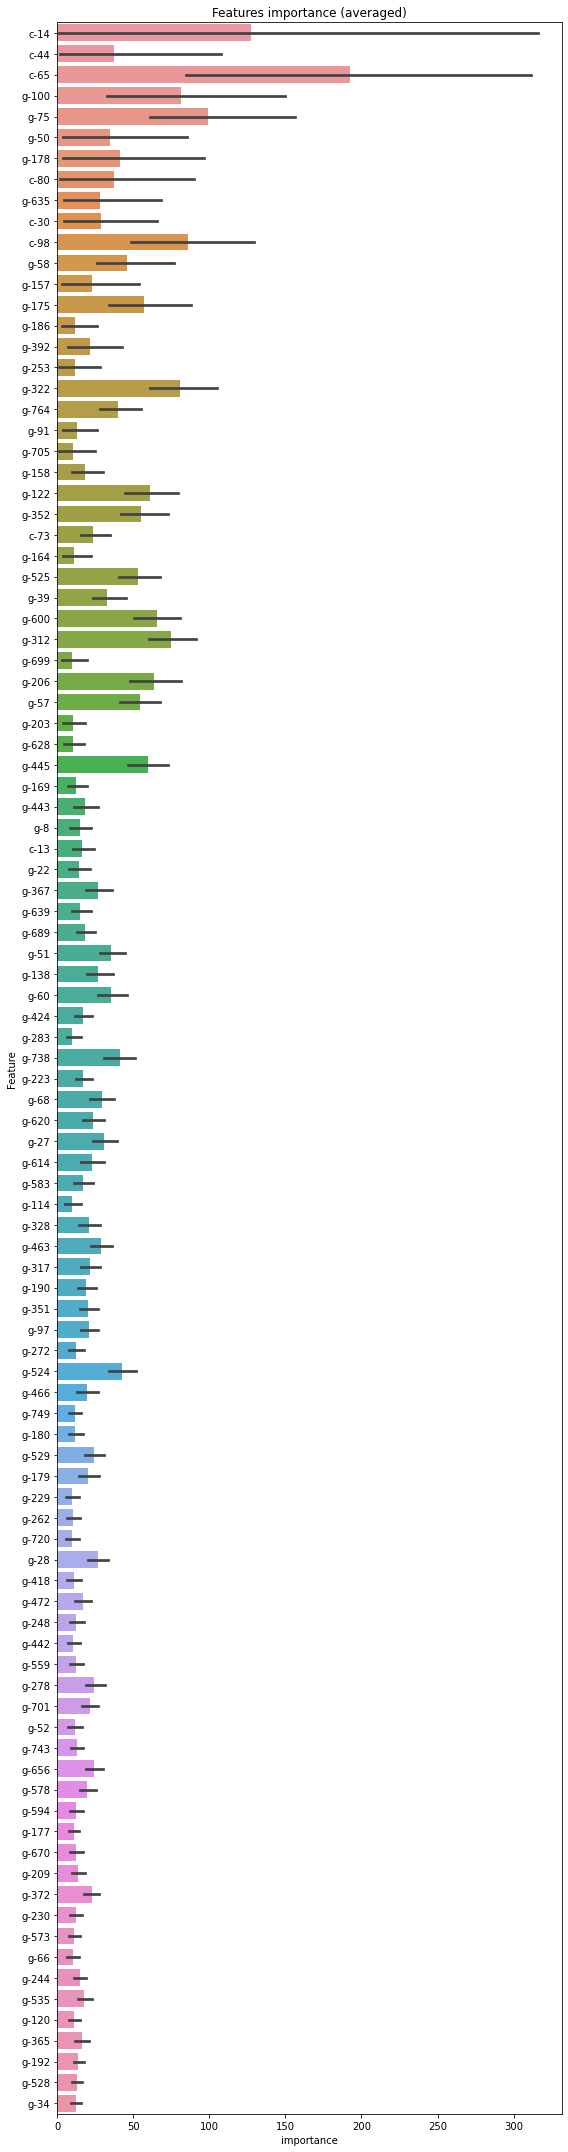

In [18]:
show_feature_importance(feature_importance_df)